In [1]:
from sstadex import Macromodel, Primitive, Test, dfs, simplediffpair, cs_pmos, cm_pmos, spice_sim, diffpair_cc, current_mirror_cc
import numpy as np
from sympy import Symbol
from sympy.solvers import solve
import matplotlib.pyplot as plt
import paretoset as pareto
import pandas as pd
from sympy import lambdify
from sstadex import Transistor
import seaborn as sns
sns.set_theme()
sns.color_palette("mako")

[(0.18195582, 0.11955283, 0.23136943),
 (0.25307401, 0.23772973, 0.48316271),
 (0.21607792, 0.39736958, 0.61948028),
 (0.20344718, 0.56074869, 0.65649508),
 (0.25187832, 0.71827158, 0.67872193),
 (0.54578602, 0.8544913, 0.69848331)]

In [2]:
## Exploration parameters

N_points = 10
lengths = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]

## Electrical parameters

Vout = 1.8                                      # LDO output voltage
Vin = 3.3                                       # LDO supply voltage
Vref = 1.35                                     # LDO voltage reference
IL = 100e-3                                     # Load current
CL = 1e-12                                      # Load capacitance
RL = Vout/IL

## LDO specifications

efficiency = 0.999
psrr_condition = -60
estability_condition = 80
linereg_condition = 0.5
loadreg_condition = 0.7
iq_condition = 20e-6
size_condition = 1e-3


I_amp1 = 20e-6
I_amp2 = 40e-6

Iq_max = IL*(1-efficiency)
Ib_pt = Iq_max-2*I_amp1-I_amp2

R1 = (Vout-Vref)/Ib_pt
R2 = Vref*R1/(Vout-Vref)

LDO = pd.DataFrame.from_dict({'Vout': [Vout], 'Vin': [Vin], 'Vref': [Vref], 'IL': [IL], 'CL': [CL], 'RL': [RL], 'Iq_max': [Iq_max], 'Ib_pt': [Ib_pt], 'R1': [R1], 'R2': [R2]}, orient='index', columns=['Value'])
LDO

,Value
Vout,1.800000e+00
Vin,3.300000e+00
Vref,1.350000e+00
IL,1.000000e-01
CL,1.000000e-12
RL,1.800000e+01
Iq_max,1.000000e-04
Ib_pt,2.000000e-05
R1,2.250000e+04
R2,6.750000e+04


# 1. Preparation

## Macromodels

In [ ]:
LDO_macro = Macromodel(
    name ='LDO_macro', 
    outputs= [
        Symbol("W_pt"), Symbol("L_pt")],
    electrical_parameters={
        "Vdd": Vin, 
        "Vref": Vref, 
        "Vout": Vout, 
        "V2stage_out": 1.7,
        "Il": IL+Ib_pt}
    )

LDO_macro.area_conditions = {
    "max": [100e-3, 100e-3, 100e-3, 100e-3, 100e-3, 100e-3, 100e-3, 100e-3],
    "min": [5e-6, 0, 5e-6, 0, 5e-6, 0, 5e-6, 0]}

OTA_2stage_macro = Macromodel(
    name = 'OTA_2stage_macro',
    outputs = [
        Symbol("W_2stage"), Symbol("L_2stage")],
    electrical_parameters = {
        "Vdd": LDO_macro.electrical_parameters["Vdd"],
        "Vref": LDO_macro.electrical_parameters["Vref"],
        "Vout": LDO_macro.electrical_parameters["V2stage_out"],
        "V1stage_out": 1.6,
        "Il": I_amp2},
    macromodel_parameters={
        Symbol('Ra'): np.logspace(3, 7, N_points),
        Symbol('gma'): np.logspace(-5, -2, N_points),
        Symbol('Ca'): np.logspace(-17, -12, N_points)}
    )

OTA_2stage_macro.area_conditions = {
    "max": [10e-3, 10e-3, 10e-3, 10e-3, 10e-3, 10e-3],
    "min": [5e-6, 0, 5e-6, 0, 5e-6, 0]}

OTA_1stage_macro = Macromodel(
    name = 'OTA_1stage_macro',
    outputs = [
        Symbol("W_diff"), Symbol("L_diff"), 
        Symbol("W_al"), Symbol("L_al"),
        Symbol('vgs_cs')],
    electrical_parameters = {
        "Vdd": OTA_2stage_macro.electrical_parameters["Vdd"],
        "Vref": OTA_2stage_macro.electrical_parameters["Vref"],
        "Vout": OTA_2stage_macro.electrical_parameters["V1stage_out"],
        "Il": I_amp1},
    macromodel_parameters={Symbol('Ra_1stage'): np.logspace(3, 7, N_points),
                                              Symbol('gma_1stage'): np.logspace(-5, -2, N_points),
                                              Symbol('Ca_1stage'): np.logspace(-17, -12, N_points)}
    )

OTA_1stage_macro.area_conditions = {
    "max": [10e-3, 10e-3, 10e-3, 10e-3],
    "min": [5e-6, 0, 5e-6, 0]}

## Primitives

In [4]:
pt = cs_pmos(
    netlist='pmos_cm.spice', 
    type='pmos', 
    inputs={
        'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-2, -0.1, 0.01), 
        'vgs': LDO_macro.electrical_parameters["V2stage_out"]-LDO_macro.electrical_parameters["Vdd"], 
        'il': LDO_macro.electrical_parameters["Il"],
        'length': lengths, 
        '2d_var': ['length', 'vgs']})

pt.build()

pt.parameters = {
    Symbol('gm_pt'): np.asarray(pt.gm).flatten(),
    Symbol('Ro_pt'): np.asarray(pt.Ro).flatten(),
    Symbol("Cgg_pt"): np.asarray(pt.cgg).flatten(),
    Symbol("Cgd_pt"): np.asarray(pt.cgd).flatten(),
    Symbol("dropout"): 2/(np.asarray(pt.gm).flatten()/pt.inputs['il'])}

pt.outputs = {
    Symbol("W_pt"): np.asarray(pt.W).flatten(),
    Symbol("L_pt"): np.asarray(pt.L).flatten()}

##############################################################################

stage2_t = cs_pmos(
    netlist='pmos_cs.spice',
    type='pmos',
    inputs={
        'vds_lut': OTA_2stage_macro.electrical_parameters["Vout"]-OTA_2stage_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-2, -0.1, 0.01), 
        'vgs': OTA_2stage_macro.electrical_parameters["V1stage_out"]-LDO_macro.electrical_parameters["Vdd"], 
        'il': OTA_2stage_macro.electrical_parameters["Il"],
        'length': lengths, 
        '2d_var': ['length', 'vgs']})

stage2_t.build()

stage2_t.parameters = {
    Symbol('gm_2stage'): np.asarray(stage2_t.gm).flatten(),
    Symbol('Ro_2stage'): np.asarray(stage2_t.Ro).flatten(),
    Symbol("Cgg_2stage"): np.asarray(stage2_t.cgg).flatten(),
    Symbol("Cgd_2stage"): np.asarray(stage2_t.cgd).flatten()}

stage2_t.outputs = {
    Symbol("W_2stage"): np.asarray(stage2_t.W).flatten(),
    Symbol("L_2stage"): np.asarray(stage2_t.L).flatten()}

##############################################################################

vs = np.linspace(0.3, 1.5, 20)
vds_diffpar = OTA_1stage_macro.electrical_parameters["Vout"] - vs
vgs_diffpar = OTA_1stage_macro.electrical_parameters["Vref"] - vs

diffpair = simplediffpair(
    netlist='diffpair.spice',
    type='nmos',
    inputs = {
        'vds_lut': (0.1, 2, 0.01),
        'vgs_lut': (0.1, 2.2, 0.01), 
        'vds': vds_diffpar, 
        'vgs': vgs_diffpar, 
        'il': I_amp1,
        'length': lengths, 
        '2d_var': ['vds', 'vgs']}
)

diffpair.build()

diffpair.parameters = {
    Symbol('gdiff_1'): np.asarray(diffpair.gm).flatten(),
    Symbol('Rdiff_1'): np.asarray(diffpair.Ro).flatten()}

diffpair.outputs = {
    Symbol("W_diff"): np.asarray(diffpair.W).flatten(),
    Symbol("L_diff"): np.asarray(diffpair.L).flatten()}

##############################################################################

activeload = cm_pmos(
    netlist='pmos_cs.spice',
    type='pmos',
    inputs={
        'vds_lut': OTA_1stage_macro.electrical_parameters["Vout"]-OTA_1stage_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-1.8, -0.1, 0.01), 
        'vgs': OTA_1stage_macro.electrical_parameters["Vout"]-OTA_1stage_macro.electrical_parameters["Vdd"], 
        'il': I_amp1,
        'length': lengths, 
        '2d_var': ['length', 'vgs']})

activeload.build()

activeload.parameters = {
    Symbol('gaload_1'): np.asarray(activeload.gm).flatten(),
    Symbol('Raload_1'): np.asarray(activeload.Ro).flatten()}

activeload.outputs = {
    Symbol("W_al"): np.asarray(activeload.W).flatten(),
    Symbol("L_al"): np.asarray(activeload.L).flatten()}

length
vgs
0
length
vgs
0
vds
vgs
1
length
vgs
0


## TestBenches

In [5]:
psrr_LDO_macro = Test()
psrr_LDO_macro.name = "psrr_LDO"
psrr_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo"
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("s"): 0,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

psrr_LDO_macro.opt_goal = "min"
psrr_LDO_macro.conditions = {"max": [1]}
psrr_LDO_macro.variables = {}
psrr_LDO_macro.out_def = {"eval": psrr_LDO_macro.tf}

##############################################################################

dc_LDO_macro = Test()
dc_LDO_macro.name = "dc_LDO"
dc_LDO_macro.tf = ["vout", "vdd"]
dc_LDO_macro.netlist = "ldo"
dc_LDO_macro.parametros = {Symbol("V1"): 3.3,
                           Symbol("V2"): 1.35,
                           Symbol("s"): 0,
                           Symbol("Rl"): RL,
                           Symbol("Cl"): CL,
                           Symbol("R1"): R1, 
                           Symbol("R2"): R2}

dc_LDO_macro.opt_goal = "min"
dc_LDO_macro.conditions = {"min": [0]}
dc_LDO_macro.variables = {}
dc_LDO_macro.out_def = {"eval": dc_LDO_macro.tf}
x = Symbol("x")
dc_LDO_macro.lamd = lambdify(x, x*3.3)

##############################################################################

gain_ol_LDO_macro = Test()
gain_ol_LDO_macro.name = "gain_ol_LDO"
gain_ol_LDO_macro.tf = ["vout", "vol"]
gain_ol_LDO_macro.netlist = "ldo_ol"
gain_ol_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("s"): 0,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

gain_ol_LDO_macro.opt_goal = "min"
gain_ol_LDO_macro.conditions = {"min": [1]}
gain_ol_LDO_macro.variables = {}
gain_ol_LDO_macro.out_def = {"eval": gain_ol_LDO_macro.tf}

##############################################################################

phase_margin_LDO_macro = Test()
phase_margin_LDO_macro.name = "phase_margin_LDO"
phase_margin_LDO_macro.tf = ["vout", "vol"]
phase_margin_LDO_macro.netlist = "ldo_ol"
phase_margin_LDO_macro.parametros = {Symbol("V3"): 1,
                             Symbol("Rl"): RL,
                             Symbol("Cl"): CL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000,
                             Symbol("C1"): 10}

phase_margin_LDO_macro.opt_goal = "min"
phase_margin_LDO_macro.conditions = {"min": [1]}
phase_margin_LDO_macro.variables = {}
phase_margin_LDO_macro.out_def = {"pm": phase_margin_LDO_macro.tf}

In [6]:
gain_2stage_OTA = Test()
gain_2stage_OTA.name = "gain_2stage"
gain_2stage_OTA.tf = ["vout", "vpos"]
gain_2stage_OTA.netlist = "OTA_2stage"
gain_2stage_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("V2"): 1,
    Symbol("I_amp2"): 0,
    Symbol("s"): 0}

gain_2stage_OTA.opt_goal = "max"
gain_2stage_OTA.conditions = {"min": [1]}
gain_2stage_OTA.variables = {}
gain_2stage_OTA.out_def = {"eval": gain_2stage_OTA.tf}

##############################################################################

rout_2stage_OTA = Test()
rout_2stage_OTA.name = "rout_2stage"
rout_2stage_OTA.target_param = Symbol("Ra")
rout_2stage_OTA.tf = ["vout", "vr"]
rout_2stage_OTA.netlist = "OTA_2stage_rout"
rout_2stage_OTA.parametros = {Symbol("gdiff_2"): Symbol("gdiff_1"),
                              Symbol("Rdiff_2"): Symbol("Rdiff_1"),
                                Symbol("gaload_2"): Symbol("gaload_1"),
                                Symbol("Raload_2"): Symbol("Raload_1"),
                                Symbol("V1"): 0,
                                Symbol("V2"): 0,
                                Symbol("Vr"): 1,
                                Symbol("I_amp2"): 0,
                                Symbol("s"): 0,
                                Symbol("Rr"): 1000}
rout_2stage_OTA.opt_goal = "max"
rout_2stage_OTA.conditions = {"min": [1]}
x = Symbol("x")
rout_2stage_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_2stage_OTA.variables = {}
rout_2stage_OTA.out_def = {"eval": rout_2stage_OTA.tf}

##################################################################

gm_2stage_OTA = Test()
gm_2stage_OTA.target_param = Symbol("gma")
gm_2stage_OTA.name = "gm_2stage"
gm_2stage_OTA.tf = ["vout", "vpos"]
gm_2stage_OTA.netlist = "ota_2stage"
gm_2stage_OTA.composed = 1
gm_2stage_OTA.out_def = {"divide": [gain_2stage_OTA, rout_2stage_OTA]}
gm_2stage_OTA.opt_goal = "max"
gm_2stage_OTA.conditions = {"min": [0.00000001]}

##################################################################

bw_2stage_OTA = Test()
bw_2stage_OTA.tf = ("vout", "vpos")
bw_2stage_OTA.name = "bw_2stage"
bw_2stage_OTA.netlist = "ota_2stage"
bw_2stage_OTA.parametros = {Symbol("gaload_2"): Symbol("gaload"),
                                Symbol("Raload_2"): Symbol("Raload_1"),
                                Symbol("gdif_2"): Symbol("gdif_1"),
                                Symbol("Rdif_2"): Symbol("Rdif_1"),
                                Symbol("V1"): 0,
                                Symbol("V2"): 1,
                                Symbol("I_amp2"): 0}

bw_2stage_OTA.conditions = {"min": [1]}
bw_2stage_OTA.variables = {}
bw_2stage_OTA.out_def = {"frec": [bw_2stage_OTA.tf, -0.70794]}

##################################################################

gds_2stage_OTA = Test()
gds_2stage_OTA.name = "gds_2stage"
gds_2stage_OTA.tf = ["vout", "vpos"]
gds_2stage_OTA.netlist = "ota_2stage"
gds_2stage_OTA.composed = 1
gds_2stage_OTA.out_def = {"divide": [1, rout_2stage_OTA]}
gds_2stage_OTA.opt_goal = "max"
gds_2stage_OTA.conditions = {"min": [0.00000001]}

##################################################################

Ca_2stage_OTA = Test()
Ca_2stage_OTA.target_param = Symbol("Ca_2stage")
Ca_2stage_OTA.name = "cout_2stage"
Ca_2stage_OTA.tf = ["vout", "vpos"]
Ca_2stage_OTA.netlist = "ota_2stage"
Ca_2stage_OTA.composed = 1
Ca_2stage_OTA.out_def = {"divide": [gds_2stage_OTA, bw_2stage_OTA]}
Ca_2stage_OTA.opt_goal = "max"
Ca_2stage_OTA.conditions = {"min": [1e-20]}

In [7]:
gain_1stage_OTA = Test()
gain_1stage_OTA.tf = ("vout", "vpos")
gain_1stage_OTA.name = "gain_1stage"
gain_1stage_OTA.netlist = "ota_1stage"
gain_1stage_OTA.parametros = {
    Symbol("gdiff_2"): Symbol("gdiff_1"),
    Symbol("Rdiff_2"): Symbol("Rdiff_1"),
    Symbol("gaload_2"): Symbol("gaload_1"),
    Symbol("Raload_2"): Symbol("Raload_1"),
    Symbol("V1"): 0,
    Symbol("V_n"): 0,
    Symbol("V_p"): 1,
    Symbol("I2"): 0,
    Symbol("s"): 0}
gain_1stage_OTA.opt_goal = "max"
gain_1stage_OTA.conditions = {"min": [1]}
gain_1stage_OTA.variables = {}
gain_1stage_OTA.out_def = {"eval": gain_1stage_OTA.tf}

##################################################################

psrr_1stage_OTA = Test()
psrr_1stage_OTA.tf = ("vout", "vdd")
psrr_1stage_OTA.name = "psrr_1stage"
psrr_1stage_OTA.netlist = "ota_1stage"
psrr_1stage_OTA.parametros = {
    Symbol("gdiff_2"): Symbol("gdiff_1"),
    Symbol("Rdiff_2"): Symbol("Rdiff_1"),
    Symbol("gaload_2"): Symbol("gaload_1"),
    Symbol("Raload_2"): Symbol("Raload_1"),
    Symbol("V1"): 1,
    Symbol("V_n"): 0,
    Symbol("V_p"): 0,
    Symbol("I2"): 0,
    Symbol("s"): 0}
psrr_1stage_OTA.opt_goal = "max"
psrr_1stage_OTA.conditions = {"min": [0.0000001]}
psrr_1stage_OTA.variables = {}
psrr_1stage_OTA.out_def = {"eval": psrr_1stage_OTA.tf}

##################################################################

rout_1stage_OTA = Test()
rout_1stage_OTA.name = "rout_1stage"
rout_1stage_OTA.target_param = Symbol("Ra_1stage")
rout_1stage_OTA.tf = ["vout", "vr"]
rout_1stage_OTA.netlist = "ota_1stage_rout"
rout_1stage_OTA.parametros = {Symbol("gdiff_2"): Symbol("gdiff_1"),
                              Symbol("Rdiff_2"): Symbol("Rdiff_1"),
                                Symbol("gaload_2"): Symbol("gaload_1"),
                                Symbol("Raload_2"): Symbol("Raload_1"),
                                Symbol("V1"): 0,
                                Symbol("V_n"): 0,
                                Symbol("V_p"): 0,
                                Symbol("Vr"): 1,
                                Symbol("I2"): 0,
                                Symbol("s"): 0,
                                Symbol("Rr"): 1000,
                                Symbol("Cl"): 1e-12}

rout_1stage_OTA.opt_goal = "max"
rout_1stage_OTA.conditions = {"min": [1]}
x = Symbol("x")
rout_1stage_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_1stage_OTA.variables = {}
rout_1stage_OTA.out_def = {"eval": rout_1stage_OTA.tf}

##################################################################

bw_1stage_OTA = Test()
bw_1stage_OTA.tf = ("vout", "vpos")
bw_1stage_OTA.name = "bw_1stage"
bw_1stage_OTA.netlist = "ota_1stage"
bw_1stage_OTA.parametros = {
    Symbol("gdiff_2"): Symbol("gdiff_1"),
    Symbol("Rdiff_2"): Symbol("Rdiff_1"),
    Symbol("gaload_2"): Symbol("gaload_1"),
    Symbol("Raload_2"): Symbol("Raload_1"),
    Symbol("V1"): 0,
    Symbol("V_n"): 0,
    Symbol("V_p"): 1,
    Symbol("I2"): 0}

bw_1stage_OTA.conditions = {"min": [1]}
bw_1stage_OTA.variables = {}
bw_1stage_OTA.out_def = {"frec": [bw_1stage_OTA.tf, -0.70794]}

##################################################################

gm_1stage_OTA = Test()
gm_1stage_OTA.target_param = Symbol("gma_1stage")
gm_1stage_OTA.name = "gm_1stage"
gm_1stage_OTA.tf = ["vout", "vpos"]
gm_1stage_OTA.netlist = "ota_1stage"
gm_1stage_OTA.composed = 1
gm_1stage_OTA.out_def = {"divide": [gain_1stage_OTA, rout_1stage_OTA]}
gm_1stage_OTA.opt_goal = "max"
gm_1stage_OTA.conditions = {"min": [0.00000001]}

##################################################################

cout_1stage_OTA = Test()
cout_1stage_OTA.target_param = Symbol("gma_1stage")
cout_1stage_OTA.name = "gm_1stage"
cout_1stage_OTA.tf = ["vout", "vpos"]
cout_1stage_OTA.netlist = "ota_1stage"
cout_1stage_OTA.composed = 1
cout_1stage_OTA.out_def = {"divide": [gain_1stage_OTA, rout_1stage_OTA]}
cout_1stage_OTA.opt_goal = "max"
cout_1stage_OTA.conditions = {"min": [0.00000001]}

# 2. Build OTA 1stage

## Exploration

In [8]:
OTA_1stage_macro.ext_mask = None
OTA_1stage_macro.conditions = {"min": [1]}

OTA_1stage_macro.primitives = [diffpair, activeload]
OTA_1stage_macro.submacromodels = []
OTA_1stage_macro.num_level_exp = 1
OTA_1stage_macro.specifications = [gain_1stage_OTA, psrr_1stage_OTA, rout_1stage_OTA, gm_1stage_OTA]
OTA_1stage_macro.opt_specifications = [gain_1stage_OTA]
OTA_1stage_macro.is_primitive = 0

ota1_results, ota1_axes, ota1_primouts, ota1_df, _, _ = dfs(OTA_1stage_macro, debug = False)

############################################
Starting the exploration of:  OTA_1stage_macro
Netlist:  ota_1stage
Running MNA... 
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[('vout', 'vpos')]
Netlist:  ota_1stage
Running MNA... 
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[('vout', 'vdd')]
Netlist:  ota_1stage_rout
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd  vr
0     1   2     3     4     5    0    6   7
[['vout', 'vr']]
Netlist:  ota_1stage
Running MNA... 
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[['vout', 'vpos']]
in eval
#### creating the primods_list ####
mod:  <sstadex.models.primitives.simplediffpair object at 0x7faae9dc0280>
mod:  <sstadex.models.primitives.cm_pmos object at 0x7faae9f83a00>
primmods_outputs_aux:  {W_diff: array([5.32753724e-07, 7.11325561e-07, 1.00088473e-06, 1.50816620e-06,
       2.49152899e-06, 4.68286013e-06, 1.06211440e-05, 3.18094256e

TypeError: cannot determine truth value of Relational

In [ ]:
ota1_df['psrr_1stage'] = 20*np.log10(ota1_df['psrr_1stage'])

In [ ]:
ota1_df["gain"] = 20*np.log10(ota1_df["gain_1stage"])

## comparation

In [ ]:
W_diff = ota1_df[Symbol("W_diff")].values*1e6
L_diff = ota1_df[Symbol("L_diff")].values*1e6

W_al = ota1_df[Symbol("W_al")].values*1e6
L_al = ota1_df[Symbol("L_al")].values*1e6

#W_s2_pf = (final_dict[Symbol("W_2stage")].values*1e6)
#L_s2_pf = (final_dict[Symbol("L_2stage")].values*1e6)

mult_diff = []
for idx, i in enumerate(W_diff):
    if i>100:
        mult_diff.append(10)
    else:
        mult_diff.append(1)

mult_al = []
for idx, i in enumerate(W_al):
    if i>100:
        mult_al.append(10)
    else:
        mult_al.append(1)

values = {
    "XM1": [
        W_diff,
        L_diff,
        mult_diff,
        "nfet",
    ],
    "XM2": [
        W_diff,
        L_diff,
        mult_diff,
        "nfet",
    ],
    "XM3": [
        W_al,
        L_al,
        mult_diff,
        "nfet",
    ],
    "XM4": [
        W_al,
        L_al,
        mult_diff,
        "nfet",
    ],
    "I2": np.full(len(W_diff), I_amp1*2)
}

simulation_results = spice_sim("ota_1stage_tb", values)

[array([5.33119356e+00, 6.28749819e+00, 6.25820355e+00, 8.44032030e+00,
       1.18741462e+01, 1.23206452e+01, 1.65222775e+01, 2.30694480e+01,
       3.39288369e+01, 5.34616370e+01, 9.26988801e+01, 1.84575116e+02,
       4.52832951e+02, 1.50677112e+03, 7.04889714e+03]), array([0.8, 1.6, 3.2, 3.2, 3.2, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4,
       6.4, 6.4]), [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10, 10, 10, 10], 'nfet']
test numer:  0
** sch_path: /workspaces/usm-vlsi-tools/shared_xserver/SSTADEx/test/Tesis_notebooks/xschem/ota_1stage_tb.sch

**.subckt ota_1stage_tb

['I2', 'vs', 'vss', '4e-05']
I2 vs vss 4e-05 

XM1
['XM1', 'vs', 'vp1', 'vout', 'vs', 'sg13_hv_nmos', 'L=0.7999999999999999u', 'W=5.3311935617759625u', 'ng=1', 'm=1']
XM1 vs vp1 vout vs sg13_hv_nmos L=0.7999999999999999u W=5.3311935617759625u ng=1 m=1 

XM2
['XM2', 'vs', 'vn', 'net1', 'vs', 'sg13_hv_nmos', 'L=0.7999999999999999u', 'W=5.3311935617759625u', 'ng=1', 'm=1']
XM2 vs vn net1 vs sg13_hv_nmos L=0.7999999999999999u W=5

In [ ]:
gain_error = []

for df in simulation_results:
    gain_error.append(float(df.columns[1]))

ota1_df["gain_sim"]=gain_error
ota1_df["gain_error"] = (np.abs(np.asarray(gain_error) - ota1_df["gain"].values)/np.asarray(gain_error))*100

ota1_df

,gdiff_1,Rdiff_1,gaload_1,Raload_1,gain_1stage,psrr_1stage,rout_1stage,gm_1stage,W_diff,L_diff,W_al,L_al,area,gain,gain_sim,gain_error
5,0.000157,5.420248e+05,0.000037,2.251707e+07,83.242269,0.0,5.424111e+05,0.000153,0.000005,8.000000e-07,0.000009,0.000006,0.000022,38.406878,38.134733,0.713641
12,0.000121,1.334361e+06,0.000037,2.251707e+07,152.345511,0.0,1.272402e+06,0.000120,0.000006,1.600000e-06,0.000009,0.000006,0.000023,43.656593,43.347877,0.712183
20,0.000089,3.427062e+06,0.000037,2.251707e+07,263.795147,0.0,2.986035e+06,0.000088,0.000006,3.200000e-06,0.000009,0.000006,0.000025,48.425336,48.092568,0.691933
21,0.000101,3.021135e+06,0.000037,2.251707e+07,267.659261,0.0,2.675591e+06,0.000100,0.000008,3.200000e-06,0.000009,0.000006,0.000027,48.551645,48.346882,0.423530
22,0.000116,2.630662e+06,0.000037,2.251707e+07,272.083398,0.0,2.367510e+06,0.000115,0.000012,3.200000e-06,0.000009,0.000006,0.000030,48.694041,48.598568,0.196451
30,0.000087,6.668702e+06,0.000037,2.251707e+07,448.948537,0.0,5.155332e+06,0.000087,0.000012,6.400000e-06,0.000009,0.000006,0.000034,53.043931,52.962778,0.153228
31,0.000099,5.882208e+06,0.000037,2.251707e+07,459.777781,0.0,4.674512e+06,0.000098,0.000017,6.400000e-06,0.000009,0.000006,0.000038,53.250960,53.234453,0.031008
32,0.000113,5.128944e+06,0.000037,2.251707e+07,471.785627,0.0,4.188361e+06,0.000113,0.000023,6.400000e-06,0.000009,0.000006,0.000045,53.474894,53.515496,0.075870
33,0.000132,4.414452e+06,0.000037,2.251707e+07,485.992342,0.0,3.702102e+06,0.000131,0.000034,6.400000e-06,0.000009,0.000006,0.000056,53.732589,53.824191,0.170189
34,0.000157,3.748498e+06,0.000037,2.251707e+07,504.662361,0.0,3.225055e+06,0.000156,0.000053,6.400000e-06,0.000009,0.000006,0.000075,54.060018,54.194287,0.247755


## Final results

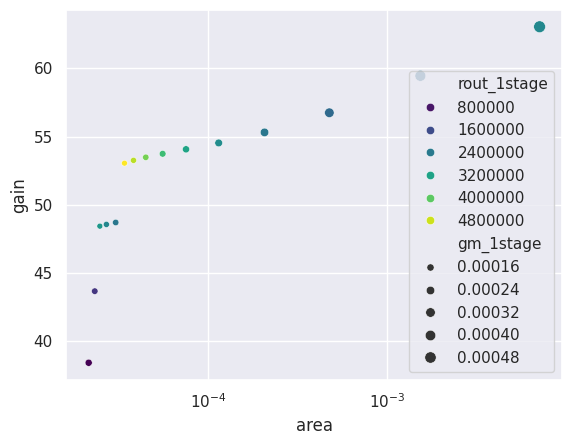

In [ ]:
sns.scatterplot(data=ota1_df, x='area', y="gain" , hue='rout_1stage', size='gm_1stage', palette='viridis')
plt.xscale("log")

# 3. Build OTA 2stage

## Create ota 1stage primitive

In [ ]:
W_diff = ota1_df[Symbol("W_diff")].values
L_diff = ota1_df[Symbol("L_diff")].values

W_al = (ota1_df[Symbol("W_al")].values)
L_al = (ota1_df[Symbol("L_al")].values)

gm_OTA_ccdiff = ota1_df["gm_1stage"].values
Ro_OTA_ccdiff = ota1_df["rout_1stage"].values

In [ ]:
OTA_1stage_primitive = Primitive(parameters={Symbol("Ra_1stage"): Ro_OTA_ccdiff,
                                  Symbol("gma_1stage"): gm_OTA_ccdiff,
                                  Symbol('Ca_1stage'): np.logspace(-17, -12, len(W_diff))})
OTA_1stage_primitive.outputs = {Symbol("W_diff"): W_diff,
                         Symbol("L_diff"): L_diff,
                         Symbol("W_al"): W_al,
                         Symbol("L_al"): L_al}

## Exploration

In [ ]:
OTA_2stage_macro.ext_mask = None

OTA_2stage_macro.primitives = [OTA_1stage_primitive, stage2_t]
OTA_2stage_macro.submacromodels = []
OTA_2stage_macro.num_level_exp = 1
OTA_2stage_macro.specifications = [gain_2stage_OTA, rout_2stage_OTA, gm_2stage_OTA, bw_2stage_OTA, gds_2stage_OTA, Ca_2stage_OTA]
OTA_2stage_macro.opt_specifications = [gain_2stage_OTA]
OTA_2stage_macro.is_primitive = 0

ota2_results, ota2_axes, ota2_primouts, ota2_df, _, _ = dfs(OTA_2stage_macro, debug = False)

############################################
Starting the exploration of:  OTA_2stage_macro
Netlist:  OTA_2stage
Running MNA... 
   vdd  vout  net1  vss  vpos
0    1     2     3    0     4
[['vout', 'vpos']]
Netlist:  OTA_2stage_rout
Running MNA... 
   vdd  vout  net1  vss  vpos  vr
0    1     2     3    0     4   5


[['vout', 'vr']]
Netlist:  ota_2stage
Running MNA... 
   vdd  vout  net1  vss  vpos
0    1     2     3    0     4
[['vout', 'vpos']]
Netlist:  ota_2stage
Running MNA... 
   vdd  vout  net1  vss  vpos
0    1     2     3    0     4
[('vout', 'vpos')]
Netlist:  ota_2stage
Running MNA... 
   vdd  vout  net1  vss  vpos
0    1     2     3    0     4
[['vout', 'vpos']]
Netlist:  ota_2stage
Running MNA... 
   vdd  vout  net1  vss  vpos
0    1     2     3    0     4
[['vout', 'vpos']]
in eval
#### creating the primods_list ####
mod:  <sstadex.models.primitives.Primitive object at 0x7f54f1410820>
mod:  <sstadex.models.primitives.cs_pmos object at 0x7f54f356ae60>


IndexError: list index out of range

In [ ]:
ota2_df["gain"] = 20*np.log10(ota2_df["gain_2stage"])

In [ ]:
ota2_df

,Ra_1stage,gma_1stage,Ca_1stage,gm_2stage,Ro_2stage,Cgg_2stage,Cgd_2stage,gain_2stage,rout_2stage,gm_2stage,...,gds_2stage,cout_2stage,W_diff,L_diff,W_al,L_al,W_2stage,L_2stage,area,gain
0,5.424111e+05,0.000153,1.000000e-17,0.000055,9.458716e+06,7.078002e-14,1.174044e-16,4.358936e+04,9.458716e+06,0.004608,...,1.057226e-07,4.758107e-14,0.000005,8.000000e-07,0.000009,0.000006,0.000007,0.000003,0.000031,92.787611
1,1.272402e+06,0.000120,2.275846e-17,0.000055,9.458716e+06,7.078002e-14,1.174044e-16,7.977490e+04,9.458716e+06,0.008434,...,1.057226e-07,1.094569e-13,0.000006,1.600000e-06,0.000009,0.000006,0.000007,0.000003,0.000033,98.037326
2,2.986035e+06,0.000088,5.179475e-17,0.000055,9.458716e+06,7.078002e-14,1.174044e-16,1.381349e+05,9.458716e+06,0.014604,...,1.057226e-07,2.762188e-13,0.000006,3.200000e-06,0.000009,0.000006,0.000007,0.000003,0.000035,102.806068
3,2.675591e+06,0.000100,1.178769e-16,0.000055,9.458716e+06,7.078002e-14,1.174044e-16,1.401583e+05,9.458716e+06,0.014818,...,1.057226e-07,2.295362e-13,0.000008,3.200000e-06,0.000009,0.000006,0.000007,0.000003,0.000037,102.932378
4,2.367510e+06,0.000115,2.682696e-16,0.000055,9.458716e+06,7.078002e-14,1.174044e-16,1.424750e+05,9.458716e+06,0.015063,...,1.057226e-07,2.092427e-13,0.000012,3.200000e-06,0.000009,0.000006,0.000007,0.000003,0.000040,103.074773
5,5.155332e+06,0.000087,6.105402e-16,0.000055,9.458716e+06,7.078002e-14,1.174044e-16,2.350895e+05,9.458716e+06,0.024854,...,1.057226e-07,4.387916e-13,0.000012,6.400000e-06,0.000009,0.000006,0.000007,0.000003,0.000044,107.424664
6,4.674512e+06,0.000098,1.389495e-15,0.000055,9.458716e+06,7.078002e-14,1.174044e-16,2.407601e+05,9.458716e+06,0.025454,...,1.057226e-07,3.999975e-13,0.000017,6.400000e-06,0.000009,0.000006,0.000007,0.000003,0.000048,107.631692
14,2.698091e+06,0.000527,1.000000e-12,0.000055,9.458716e+06,7.078002e-14,1.174044e-16,7.438725e+05,9.458716e+06,0.078644,...,1.057226e-07,2.116778e-12,0.007049,6.400000e-06,0.000009,0.000006,0.000007,0.000003,0.007081,117.429970
20,5.155332e+06,0.000087,6.105402e-16,0.000056,1.365679e+07,2.916952e-13,3.459410e-16,3.416337e+05,1.365679e+07,0.025016,...,7.322364e-08,1.336466e-12,0.000012,6.400000e-06,0.000009,0.000006,0.000014,0.000006,0.000054,110.671214
21,4.674512e+06,0.000098,1.389495e-15,0.000056,1.365679e+07,2.916952e-13,3.459410e-16,3.498743e+05,1.365679e+07,0.025619,...,7.322364e-08,1.218307e-12,0.000017,6.400000e-06,0.000009,0.000006,0.000014,0.000006,0.000058,110.878242


## Comparation

In [ ]:
W_diff = ota2_df[Symbol("W_diff")].values*1e6
L_diff = ota2_df[Symbol("L_diff")].values*1e6

W_al = ota2_df[Symbol("W_al")].values*1e6
L_al = ota2_df[Symbol("L_al")].values*1e6

W_2stage = (ota2_df[Symbol("W_2stage")].values*1e6)
L_2stage = (ota2_df[Symbol("L_2stage")].values*1e6)

mult_diff = []
for idx, i in enumerate(W_diff):
    if i>100:
        mult_diff.append(10)
    else:
        mult_diff.append(1)

mult_al = []
for idx, i in enumerate(W_al):
    if i>100:
        mult_al.append(10)
    else:
        mult_al.append(1)

values = {
    "XM1": [
        W_diff,
        L_diff,
        mult_diff,
        "nfet",
    ],
    "XM2": [
        W_diff,
        L_diff,
        mult_diff,
        "nfet",
    ],
    "XM3": [
        W_al,
        L_al,
        mult_diff,
        "nfet",
    ],
    "XM4": [
        W_al,
        L_al,
        mult_diff,
        "nfet",
    ],
    "XM5": [
        W_2stage,
        L_2stage,
        mult_diff,
        "nfet",
    ],
    "I1": np.full(len(W_diff), I_amp1*2),
    "I2": np.full(len(W_diff), I_amp2)
}

simulation_results = spice_sim("ota_2stage_tb", values)

[array([5.33119356e+00, 6.28749819e+00, 6.25820355e+00, 8.44032030e+00,
       1.18741462e+01, 1.23206452e+01, 1.65222775e+01, 7.04889714e+03,
       1.23206452e+01, 1.65222775e+01, 2.30694480e+01, 3.39288369e+01,
       5.34616370e+01, 9.26988801e+01, 1.84575116e+02, 4.52832951e+02,
       1.50677112e+03, 7.04889714e+03]), array([0.8, 1.6, 3.2, 3.2, 3.2, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4,
       6.4, 6.4, 6.4, 6.4, 6.4]), [1, 1, 1, 1, 1, 1, 1, 10, 1, 1, 1, 1, 1, 1, 10, 10, 10, 10], 'nfet']
test numer:  0
** sch_path: /workspaces/usm-vlsi-tools/shared_xserver/SSTADEx/test/Tesis_notebooks/xschem/ota_2stage_tb.sch

**.subckt ota_2stage_tb

['I1', 'vs', 'vss', '4e-05']
I1 vs vss 4e-05 

['I2', 'vout', 'vss', '3e-05']
I2 vout vss 3e-05 

XM1
['XM1', 'vout_s1', 'vn', 'vs', 'vs', 'sg13_hv_nmos', 'L=0.7999999999999999u', 'W=5.3311935617759625u', 'ng=1', 'm=1']
XM1 vout_s1 vn vs vs sg13_hv_nmos L=0.7999999999999999u W=5.3311935617759625u ng=1 m=1 

XM2
['XM2', 'net2', 'net1', 'vs', 'vs', 

Note: Dynamic gmin stepping completed

Note: No compatibility mode selected!


Circuit: ** sch_path: /workspaces/usm-vlsi-tools/shared_xserver/sstadex/test/tesis_notebooks/xschem/ota_2stage_tb.sch

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

 Reference value :  1.00000e+00
No. of Data Rows : 91
Note: Simulation executed from .control section 
test numer:  1
** sch_path: /workspaces/usm-vlsi-tools/shared_xserver/SSTADEx/test/Tesis_notebooks/xschem/ota_2stage_tb.sch

**.subckt ota_2stage_tb

['I1', 'vs', 'vss', '4e-05']
I1 vs vss 4e-05 

['I2', 'vout', 'vss', '3e-05']
I2 vout vss 3e-05 

XM1
['XM1', 'vout_s1', 'vn', 'vs', 'vs', 'sg13_hv_nmos', 'L=1.5999999999999999u', 'W=6.2874981888373975u', 'ng=1', 'm=1']
XM1 vout_s1 vn vs vs sg13_hv_nmos L=1.5999999999999999u W=6.2874981888373975u ng=1 m=1 

XM2
['XM2', 'net2', 'net1', 'vs', 'vs', 'sg13_hv_nmos', 'L=1.5999999999999999u', 'W=6.2874981888373975u', 'ng=1', 'm=1']
XM2 net2 net1 vs vs sg13_hv_nmos L=1.5999999999999999u W=6.287

In [ ]:
gain_error = []

for df in simulation_results:
    gain_error.append(float(df.columns[1]))

ota2_df["gain_sim"]=gain_error
ota2_df["gain_error"] = (np.abs(np.asarray(gain_error) - ota2_df["gain"].values)/np.asarray(gain_error))*100

ota2_df

,Ra_1stage,gma_1stage,Ca_1stage,gm_2stage,Ro_2stage,Cgg_2stage,Cgd_2stage,gain_2stage,rout_2stage,gm_2stage,...,W_diff,L_diff,W_al,L_al,W_2stage,L_2stage,area,gain,gain_sim,gain_error
0,5.424111e+05,0.000153,1.000000e-17,0.000055,9.458716e+06,7.078002e-14,1.174044e-16,4.358936e+04,9.458716e+06,0.004608,...,0.000005,8.000000e-07,0.000009,0.000006,0.000007,0.000003,0.000031,92.787611,93.102335,0.338041
1,1.272402e+06,0.000120,2.275846e-17,0.000055,9.458716e+06,7.078002e-14,1.174044e-16,7.977490e+04,9.458716e+06,0.008434,...,0.000006,1.600000e-06,0.000009,0.000006,0.000007,0.000003,0.000033,98.037326,98.319126,0.286618
2,2.986035e+06,0.000088,5.179475e-17,0.000055,9.458716e+06,7.078002e-14,1.174044e-16,1.381349e+05,9.458716e+06,0.014604,...,0.000006,3.200000e-06,0.000009,0.000006,0.000007,0.000003,0.000035,102.806068,103.065059,0.251288
3,2.675591e+06,0.000100,1.178769e-16,0.000055,9.458716e+06,7.078002e-14,1.174044e-16,1.401583e+05,9.458716e+06,0.014818,...,0.000008,3.200000e-06,0.000009,0.000006,0.000007,0.000003,0.000037,102.932378,103.319669,0.374847
4,2.367510e+06,0.000115,2.682696e-16,0.000055,9.458716e+06,7.078002e-14,1.174044e-16,1.424750e+05,9.458716e+06,0.015063,...,0.000012,3.200000e-06,0.000009,0.000006,0.000007,0.000003,0.000040,103.074773,103.571676,0.479767
5,5.155332e+06,0.000087,6.105402e-16,0.000055,9.458716e+06,7.078002e-14,1.174044e-16,2.350895e+05,9.458716e+06,0.024854,...,0.000012,6.400000e-06,0.000009,0.000006,0.000007,0.000003,0.000044,107.424664,107.935406,0.473193
6,4.674512e+06,0.000098,1.389495e-15,0.000055,9.458716e+06,7.078002e-14,1.174044e-16,2.407601e+05,9.458716e+06,0.025454,...,0.000017,6.400000e-06,0.000009,0.000006,0.000007,0.000003,0.000048,107.631692,108.207655,0.532276
14,2.698091e+06,0.000527,1.000000e-12,0.000055,9.458716e+06,7.078002e-14,1.174044e-16,7.438725e+05,9.458716e+06,0.078644,...,0.007049,6.400000e-06,0.000009,0.000006,0.000007,0.000003,0.007081,117.429970,118.185646,0.639398
20,5.155332e+06,0.000087,6.105402e-16,0.000056,1.365679e+07,2.916952e-13,3.459410e-16,3.416337e+05,1.365679e+07,0.025016,...,0.000012,6.400000e-06,0.000009,0.000006,0.000014,0.000006,0.000054,110.671214,111.035146,0.327763
21,4.674512e+06,0.000098,1.389495e-15,0.000056,1.365679e+07,2.916952e-13,3.459410e-16,3.498743e+05,1.365679e+07,0.025619,...,0.000017,6.400000e-06,0.000009,0.000006,0.000014,0.000006,0.000058,110.878242,111.305728,0.384065


## Final results

/tmp/ipykernel_58222/2263286662.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=ota2_df, x='area', y="gain" , palette='viridis')


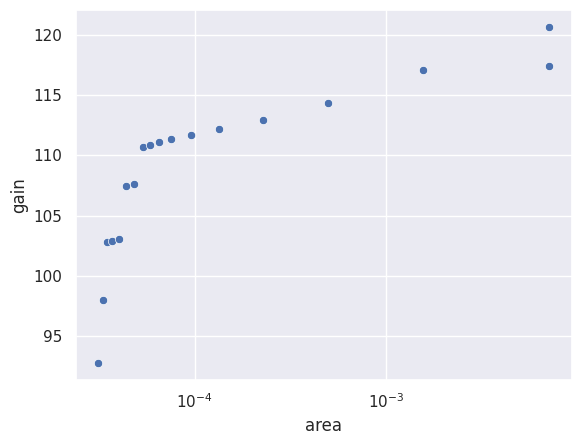

In [ ]:
sns.scatterplot(data=ota2_df, x='area', y="gain" , palette='viridis')
plt.xscale("log")

# 4. LDO

## Create OTA 2stage

In [ ]:
W_diff = ota2_df[Symbol("W_diff")].values
L_diff = ota2_df[Symbol("L_diff")].values

W_al = ota2_df[Symbol("W_al")].values
L_al = ota2_df[Symbol("L_al")].values

W_2stage = ota2_df[Symbol("W_2stage")].values
L_2stage = ota2_df[Symbol("L_2stage")].values

gm_OTA_ccdiff = ota2_df["gm_2stage"].values
Ro_OTA_ccdiff = ota2_df["rout_2stage"].values

NameError: name 'ota2_df' is not defined

In [ ]:
OTA_2stage_primitive = Primitive(parameters={Symbol("Ra"): Ro_OTA_ccdiff,
                                  Symbol("gma"): gm_OTA_ccdiff,
                                  Symbol("Ca"): ota2_df["cout_2stage"].values})
OTA_2stage_primitive.outputs = {Symbol("W_diff"): W_diff, Symbol("L_diff"): L_diff, 
                                Symbol("W_al"): W_al, Symbol("L_al"): L_al,
                                Symbol("W_2stage"): W_2stage, Symbol("L_2stage"): L_2stage}

## Exploration

In [ ]:
LDO_macro.ext_mask = None

LDO_macro.primitives=[OTA_2stage_primitive, pt]
LDO_macro.submacromodels=[]
LDO_macro.num_level_exp=-1
LDO_macro.specifications=[psrr_LDO_macro]
LDO_macro.opt_specifications=[psrr_LDO_macro]
LDO_macro.is_primitive=0

ldo_results, ldo_axes, ldo_primouts, ldo_df, _ = dfs(LDO_macro, debug = False)

############################################
Starting the exploration of:  ldo
Netlist:  ldo
Running MNA... 
   vdd  vout  net1  vfb  vss
0    1     2     3    4    0
[['vout', 'vdd']]
in eval
#### creating the primods_list ####
mod:  <sstadex.models.primitives.Primitive object at 0x7fe2ed008e80>
mod:  <sstadex.models.primitives.cs_pmos object at 0x7fe2ed15f8e0>
eval:  [3.14028673e-05 1.71587447e-05 9.90944593e-06 9.76638677e-06
 9.60758359e-06 5.82264317e-06 5.68550146e-06 1.84015931e-06
 4.00675626e-06 3.91238439e-06 3.81280686e-06 3.70134955e-06
 3.56441802e-06 3.37747986e-06 3.08943983e-06 2.61741538e-06
 1.91702556e-06 1.26627491e-06 3.08309349e-05 1.68462283e-05
 9.72896028e-06 9.58850668e-06 9.43259581e-06 5.71659165e-06
 5.58194777e-06 1.80664306e-06 3.93377840e-06 3.84112538e-06
 3.74336150e-06 3.63393423e-06 3.49949672e-06 3.31596337e-06
 3.03316959e-06 2.56974243e-06 1.88210929e-06 1.24321123e-06
 3.06795685e-05 1.67635179e-05 9.68119291e-06 9.54142889e-06
 9.38628349e-06 5.

In [ ]:
ldo_df["psrr"]= 20*np.log10(ldo_df["psrr_LDO"])

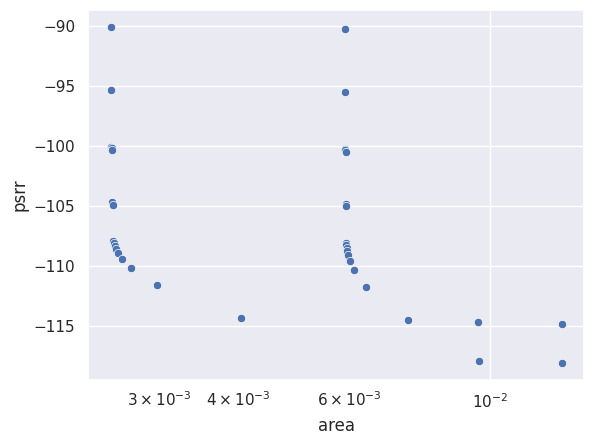

In [ ]:
sns.scatterplot(data=ldo_df, x='area', y="psrr")
plt.xscale("log")

In [ ]:
ldo_df

,Ra,gma,Ca,gm_pt,Ro_pt,Cgg_pt,Cgd_pt,psrr_LDO,W_diff,L_diff,W_al,L_al,W_2stage,L_2stage,W_pt,L_pt,area,psrr
0,9.458716e+06,0.004608,4.758107e-14,0.185899,201.973430,3.135323e-12,4.025270e-14,0.000031,0.000005,8.000000e-07,0.000009,0.000006,0.000007,0.000003,0.002488,4.000000e-07,0.002520,-90.060614
1,9.458716e+06,0.008434,1.094569e-13,0.185899,201.973430,3.135323e-12,4.025270e-14,0.000017,0.000006,1.600000e-06,0.000009,0.000006,0.000007,0.000003,0.002488,4.000000e-07,0.002522,-95.310290
2,9.458716e+06,0.014604,2.762188e-13,0.185899,201.973430,3.135323e-12,4.025270e-14,0.000010,0.000006,3.200000e-06,0.000009,0.000006,0.000007,0.000003,0.002488,4.000000e-07,0.002523,-100.079013
3,9.458716e+06,0.014818,2.295362e-13,0.185899,201.973430,3.135323e-12,4.025270e-14,0.000010,0.000008,3.200000e-06,0.000009,0.000006,0.000007,0.000003,0.002488,4.000000e-07,0.002526,-100.205322
4,9.458716e+06,0.015063,2.092427e-13,0.185899,201.973430,3.135323e-12,4.025270e-14,0.000010,0.000012,3.200000e-06,0.000009,0.000006,0.000007,0.000003,0.002488,4.000000e-07,0.002529,-100.347717
5,9.458716e+06,0.024854,4.387916e-13,0.185899,201.973430,3.135323e-12,4.025270e-14,0.000006,0.000012,6.400000e-06,0.000009,0.000006,0.000007,0.000003,0.002488,4.000000e-07,0.002533,-104.697596
6,9.458716e+06,0.025454,3.999975e-13,0.185899,201.973430,3.135323e-12,4.025270e-14,0.000006,0.000017,6.400000e-06,0.000009,0.000006,0.000007,0.000003,0.002488,4.000000e-07,0.002537,-104.904624
7,9.458716e+06,0.078644,2.116778e-12,0.185899,201.973430,3.135323e-12,4.025270e-14,0.000002,0.007049,6.400000e-06,0.000009,0.000006,0.000007,0.000003,0.002488,4.000000e-07,0.009569,-114.702892
8,1.365679e+07,0.025016,1.336466e-12,0.185899,201.973430,3.135323e-12,4.025270e-14,0.000004,0.000012,6.400000e-06,0.000009,0.000006,0.000014,0.000006,0.002488,4.000000e-07,0.002543,-107.944142
9,1.365679e+07,0.025619,1.218307e-12,0.185899,201.973430,3.135323e-12,4.025270e-14,0.000004,0.000017,6.400000e-06,0.000009,0.000006,0.000014,0.000006,0.002488,4.000000e-07,0.002547,-108.151170


## Comparation

In [ ]:
W_diff = ldo_df[Symbol("W_diff")].values*1e6
L_diff = ldo_df[Symbol("L_diff")].values*1e6

W_al = ldo_df[Symbol("W_al")].values*1e6
L_al = ldo_df[Symbol("L_al")].values*1e6

W_2stage = (ldo_df[Symbol("W_2stage")].values*1e6)
L_2stage = (ldo_df[Symbol("L_2stage")].values*1e6)

W_pt = ldo_df[Symbol("W_pt")].values*1e6
L_pt = ldo_df[Symbol("L_pt")].values*1e6

mult_diff = []
for idx, i in enumerate(W_diff):
    if i>100:
        mult_diff.append(10)
    else:
        mult_diff.append(1)

mult_al = []
for idx, i in enumerate(W_al):
    if i>100:
        mult_al.append(10)
    else:
        mult_al.append(1)

values = {
    "XM1": [
        W_diff,
        L_diff,
        mult_diff,
        "nfet",
    ],
    "XM2": [
        W_diff,
        L_diff,
        mult_diff,
        "nfet",
    ],
    "XM3": [
        W_al,
        L_al,
        mult_diff,
        "nfet",
    ],
    "XM4": [
        W_al,
        L_al,
        mult_diff,
        "nfet",
    ],
    "XM5": [
        W_2stage,
        L_2stage,
        mult_diff,
        "nfet",
    ],
    "XM6": [
        W_pt,
        L_pt,
        mult_diff,
        "nfet",
    ],
    "I_amp1": np.full(len(W_diff), I_amp1*2),
    "I_amp2": np.full(len(W_diff), I_amp2)
}

simulation_results = spice_sim("ldo_tb", values)

[array([5.33119356e+00, 6.28749819e+00, 6.25820355e+00, 8.44032030e+00,
       1.18741462e+01, 1.23206452e+01, 1.65222775e+01, 7.04889714e+03,
       1.23206452e+01, 1.65222775e+01, 2.30694480e+01, 3.39288369e+01,
       5.34616370e+01, 9.26988801e+01, 1.84575116e+02, 4.52832951e+02,
       1.50677112e+03, 7.04889714e+03, 5.33119356e+00, 6.28749819e+00,
       6.25820355e+00, 8.44032030e+00, 1.18741462e+01, 1.23206452e+01,
       1.65222775e+01, 7.04889714e+03, 1.23206452e+01, 1.65222775e+01,
       2.30694480e+01, 3.39288369e+01, 5.34616370e+01, 9.26988801e+01,
       1.84575116e+02, 4.52832951e+02, 1.50677112e+03, 7.04889714e+03]), array([0.8, 1.6, 3.2, 3.2, 3.2, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4,
       6.4, 6.4, 6.4, 6.4, 6.4, 0.8, 1.6, 3.2, 3.2, 3.2, 6.4, 6.4, 6.4,
       6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4]), [1, 1, 1, 1, 1, 1, 1, 10, 1, 1, 1, 1, 1, 1, 10, 10, 10, 10, 1, 1, 1, 1, 1, 1, 1, 10, 1, 1, 1, 1, 1, 1, 10, 10, 10, 10], 'nfet']
test numer:  0
** sch_path:

In [ ]:
psrr_error = []

for df in simulation_results:
    psrr_error.append(float(df.columns[1]))

ldo_df["psrr_sim"]=psrr_error
ldo_df["psrr_error"] = (np.abs(np.asarray(psrr_error) - ldo_df["psrr"].values)/np.asarray(psrr_error))*100

ldo_df

,Ra,gma,Ca,gm_pt,Ro_pt,Cgg_pt,Cgd_pt,psrr_LDO,W_diff,L_diff,W_al,L_al,W_2stage,L_2stage,W_pt,L_pt,area,psrr,psrr_sim,psrr_error
0,9.458716e+06,0.004608,4.758107e-14,0.185899,201.973430,3.135323e-12,4.025270e-14,0.000031,0.000005,8.000000e-07,0.000009,0.000006,0.000007,0.000003,0.002488,4.000000e-07,0.002520,-90.060614,-90.005324,-0.061430
1,9.458716e+06,0.008434,1.094569e-13,0.185899,201.973430,3.135323e-12,4.025270e-14,0.000017,0.000006,1.600000e-06,0.000009,0.000006,0.000007,0.000003,0.002488,4.000000e-07,0.002522,-95.310290,-95.221843,-0.092885
2,9.458716e+06,0.014604,2.762188e-13,0.185899,201.973430,3.135323e-12,4.025270e-14,0.000010,0.000006,3.200000e-06,0.000009,0.000006,0.000007,0.000003,0.002488,4.000000e-07,0.002523,-100.079013,-99.967659,-0.111389
3,9.458716e+06,0.014818,2.295362e-13,0.185899,201.973430,3.135323e-12,4.025270e-14,0.000010,0.000008,3.200000e-06,0.000009,0.000006,0.000007,0.000003,0.002488,4.000000e-07,0.002526,-100.205322,-100.222249,-0.016890
4,9.458716e+06,0.015063,2.092427e-13,0.185899,201.973430,3.135323e-12,4.025270e-14,0.000010,0.000012,3.200000e-06,0.000009,0.000006,0.000007,0.000003,0.002488,4.000000e-07,0.002529,-100.347717,-100.474235,-0.125921
5,9.458716e+06,0.024854,4.387916e-13,0.185899,201.973430,3.135323e-12,4.025270e-14,0.000006,0.000012,6.400000e-06,0.000009,0.000006,0.000007,0.000003,0.002488,4.000000e-07,0.002533,-104.697596,-104.837782,-0.133717
6,9.458716e+06,0.025454,3.999975e-13,0.185899,201.973430,3.135323e-12,4.025270e-14,0.000006,0.000017,6.400000e-06,0.000009,0.000006,0.000007,0.000003,0.002488,4.000000e-07,0.002537,-104.904624,-105.110001,-0.195392
7,9.458716e+06,0.078644,2.116778e-12,0.185899,201.973430,3.135323e-12,4.025270e-14,0.000002,0.007049,6.400000e-06,0.000009,0.000006,0.000007,0.000003,0.002488,4.000000e-07,0.009569,-114.702892,-115.048201,-0.300143
8,1.365679e+07,0.025016,1.336466e-12,0.185899,201.973430,3.135323e-12,4.025270e-14,0.000004,0.000012,6.400000e-06,0.000009,0.000006,0.000014,0.000006,0.002488,4.000000e-07,0.002543,-107.944142,-107.954548,-0.009640
9,1.365679e+07,0.025619,1.218307e-12,0.185899,201.973430,3.135323e-12,4.025270e-14,0.000004,0.000017,6.400000e-06,0.000009,0.000006,0.000014,0.000006,0.002488,4.000000e-07,0.002547,-108.151170,-108.225110,-0.068321


# Direct build

In [ ]:
LDO_macro.primitives = [pt]
LDO_macro.submacromodels = [OTA_2stage_macro]
LDO_macro.num_level_exp = -1
LDO_macro.specifications = [psrr_LDO_macro, dc_LDO_macro, gain_ol_LDO_macro, phase_margin_LDO_macro]
LDO_macro.opt_specifications = [psrr_LDO_macro]
LDO_macro.is_primitive = 0

OTA_2stage_macro.primitives = [stage2_t]
OTA_2stage_macro.submacromodels = [OTA_1stage_macro]
OTA_2stage_macro.num_level_exp = -1
OTA_2stage_macro.specifications = [gain_2stage_OTA, rout_2stage_OTA, gm_2stage_OTA, gds_2stage_OTA, Ca_2stage_OTA]
OTA_2stage_macro.opt_specifications = [gain_2stage_OTA]
OTA_2stage_macro.is_primitive = 0

OTA_1stage_macro.primitives = [diffpair, activeload]
OTA_1stage_macro.submacromodels = []
OTA_1stage_macro.num_level_exp = -1
OTA_1stage_macro.specifications = [gain_1stage_OTA, rout_1stage_OTA, gm_1stage_OTA]
OTA_1stage_macro.opt_specifications = [gain_1stage_OTA]
OTA_1stage_macro.is_primitive = 0

ldo_results, ldo_axes, ldo_primouts, ldo_df, _ = dfs(LDO_macro, debug = False)

############################################
Starting the exploration of:  LDO_macro
Netlist:  ldo
Running MNA... 
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo
Running MNA... 
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo_ol
Running MNA... 
   vpos  vfb  vss  vout  net1  vol
0     1    2    0     3     4    5
[['vout', 'vol']]
Netlist:  ldo_ol
Running MNA... 
   vpos  vfb  vss  vout  net1  vol
0     1    2    0     3     4    5
[['vout', 'vol']]
in eval
#### creating the primods_list ####
mod:  <sstadex.models.macromodel.Macromodel object at 0x7f4126c4ef20>
mod:  <sstadex.models.primitives.cs_pmos object at 0x7f4126cab130>
eval:  [3.08232978e+00 3.39893635e+00 3.52471654e+00 ... 1.33730926e-05
 1.33570508e-05 1.33496789e-05]
in eval
#### creating the primods_list ####
mod:  <sstadex.models.macromodel.Macromodel object at 0x7f4126c4ef20>
mod:  <sstadex.models.primitives.cs_pm

In [ ]:
ldo_df['psrr'] = 20*np.log10(ldo_df['psrr_LDO'])
ldo_df['gain_ol'] = 20*np.log10(ldo_df['gain_ol_LDO'])
ldo_df

,Ra,gma,Ca,gm_pt,Ro_pt,Cgg_pt,Cgd_pt,dropout,psrr_LDO,dc_LDO,...,L_diff,W_al,L_al,W_2stage,L_2stage,W_pt,L_pt,area,psrr,gain_ol
0,7.094037e+06,0.006145,1.000000e-17,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000031,1.800086,...,8.000000e-07,0.000009,0.000006,0.000009,0.000003,0.002488,4.000000e-07,0.002522,-90.060614,102.534707
1,7.094037e+06,0.011245,3.593814e-17,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000017,1.800047,...,1.600000e-06,0.000009,0.000006,0.000009,0.000003,0.002488,4.000000e-07,0.002524,-95.310290,107.784422
2,7.094037e+06,0.019472,1.291550e-16,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000010,1.800027,...,3.200000e-06,0.000009,0.000006,0.000009,0.000003,0.002488,4.000000e-07,0.002525,-100.079013,112.553164
3,7.094037e+06,0.019757,4.641589e-16,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000010,1.800027,...,3.200000e-06,0.000009,0.000006,0.000009,0.000003,0.002488,4.000000e-07,0.002528,-100.205322,112.679474
4,7.094037e+06,0.020084,1.668101e-15,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000010,1.800026,...,3.200000e-06,0.000009,0.000006,0.000009,0.000003,0.002488,4.000000e-07,0.002531,-100.347717,112.821869
5,7.094037e+06,0.033139,5.994843e-15,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000006,1.800016,...,6.400000e-06,0.000009,0.000006,0.000009,0.000003,0.002488,4.000000e-07,0.002535,-104.697596,117.171760
6,7.094037e+06,0.033938,2.154435e-14,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000006,1.800016,...,6.400000e-06,0.000009,0.000006,0.000009,0.000003,0.002488,4.000000e-07,0.002539,-104.904624,117.378788
7,7.094037e+06,0.034825,7.742637e-14,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000006,1.800015,...,6.400000e-06,0.000009,0.000006,0.000009,0.000003,0.002488,4.000000e-07,0.002545,-105.128559,117.602722
8,7.094037e+06,0.104859,2.782559e-13,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000002,1.800005,...,6.400000e-06,0.000009,0.000006,0.000009,0.000003,0.002488,4.000000e-07,0.009571,-114.702892,127.177066
9,1.024259e+07,0.033354,1.000000e-12,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000004,1.800011,...,6.400000e-06,0.000009,0.000006,0.000018,0.000006,0.002488,4.000000e-07,0.002547,-107.944142,120.418310


/tmp/ipykernel_590/1089315490.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=ldo_df, x='area', y="psrr" , palette='viridis')


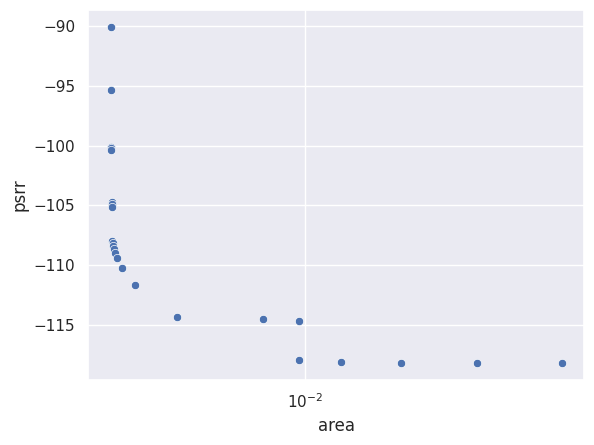

In [ ]:
sns.scatterplot(data=ldo_df, x='area', y="psrr" , palette='viridis')
plt.xscale("log")

In [ ]:
W_diff = ldo_df[Symbol("W_diff")].values*1e6
L_diff = ldo_df[Symbol("L_diff")].values*1e6

W_al = ldo_df[Symbol("W_al")].values*1e6
L_al = ldo_df[Symbol("L_al")].values*1e6

W_2stage = (ldo_df[Symbol("W_2stage")].values*1e6)
L_2stage = (ldo_df[Symbol("L_2stage")].values*1e6)

W_pt = ldo_df[Symbol("W_pt")].values*1e6
L_pt = ldo_df[Symbol("L_pt")].values*1e6

mult_diff = []
for idx, i in enumerate(W_diff):
    if i>100:
        mult_diff.append(10)
    else:
        mult_diff.append(1)

mult_al = []
for idx, i in enumerate(W_al):
    if i>100:
        mult_al.append(10)
    else:
        mult_al.append(1)

values = {
    "XM1": [
        W_diff,
        L_diff,
        mult_diff,
        "nfet",
    ],
    "XM2": [
        W_diff,
        L_diff,
        mult_diff,
        "nfet",
    ],
    "XM3": [
        W_al,
        L_al,
        mult_diff,
        "nfet",
    ],
    "XM4": [
        W_al,
        L_al,
        mult_diff,
        "nfet",
    ],
    "XM5": [
        W_2stage,
        L_2stage,
        mult_diff,
        "nfet",
    ],
    "XM6": [
        W_pt,
        L_pt,
        mult_diff,
        "nfet",
    ],
    "I_amp1": np.full(len(W_diff), I_amp1*2),
    "I_amp2": np.full(len(W_diff), I_amp2),
    "R1": np.full(len(W_diff), 22500),
    "R2": np.full(len(W_diff), 67500)
}

simulation_results = spice_sim("ldo_tb", values)

[array([5.33119356e+00, 6.28749819e+00, 6.25820355e+00, 8.44032030e+00,
       1.18741462e+01, 1.23206452e+01, 1.65222775e+01, 2.30694480e+01,
       7.04889714e+03, 1.23206452e+01, 1.65222775e+01, 2.30694480e+01,
       3.39288369e+01, 5.34616370e+01, 9.26988801e+01, 1.84575116e+02,
       4.52832951e+02, 1.50677112e+03, 7.04889714e+03, 1.50677112e+03,
       7.04889714e+03, 7.04889714e+03, 7.04889714e+03, 7.04889714e+03]), array([0.8, 1.6, 3.2, 3.2, 3.2, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4,
       6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4]), [1, 1, 1, 1, 1, 1, 1, 1, 10, 1, 1, 1, 1, 1, 1, 10, 10, 10, 10, 10, 10, 10, 10, 10], 'nfet']
test numer:  0
** sch_path: /workspaces/usm-vlsi-tools/shared_xserver/SSTADEx/test/Tesis_notebooks/xschem/ldo_tb.sch

**.subckt ldo_tb

['I_amp1', 'vs', 'vss', '4e-05']
I_amp1 vs vss 4e-05 

['I_amp2', 'vmid', 'vss', '4e-05']
I_amp2 vmid vss 4e-05 

['R1', 'vout', 'vfb', '22500', 'm=1']
R1 vout vfb 22500 m=1 

['R2', 'vfb', 'vss', '67500', '

In [ ]:
gain_error = []

for df in simulation_results:
    gain_error.append(float(df.columns[1]))

ldo_df["psrr_sim"]=gain_error
ldo_df["psrr_error"] = (np.abs(np.asarray(gain_error) - ldo_df["psrr"].values)/np.asarray(gain_error))*100

ldo_df

,Ra,gma,Ca,gm_pt,Ro_pt,Cgg_pt,Cgd_pt,dropout,psrr_LDO,dc_LDO,...,L_al,W_2stage,L_2stage,W_pt,L_pt,area,psrr,gain_ol,psrr_sim,psrr_error
0,7.094037e+06,0.006145,1.000000e-17,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000031,1.800086,...,0.000006,0.000009,0.000003,0.002488,4.000000e-07,0.002522,-90.060614,102.534707,-89.946566,-0.126796
1,7.094037e+06,0.011245,3.593814e-17,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000017,1.800047,...,0.000006,0.000009,0.000003,0.002488,4.000000e-07,0.002524,-95.310290,107.784422,-95.160826,-0.157064
2,7.094037e+06,0.019472,1.291550e-16,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000010,1.800027,...,0.000006,0.000009,0.000003,0.002488,4.000000e-07,0.002525,-100.079013,112.553164,-99.907026,-0.172147
3,7.094037e+06,0.019757,4.641589e-16,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000010,1.800027,...,0.000006,0.000009,0.000003,0.002488,4.000000e-07,0.002528,-100.205322,112.679474,-100.161177,-0.044074
4,7.094037e+06,0.020084,1.668101e-15,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000010,1.800026,...,0.000006,0.000009,0.000003,0.002488,4.000000e-07,0.002531,-100.347717,112.821869,-100.412697,-0.064713
5,7.094037e+06,0.033139,5.994843e-15,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000006,1.800016,...,0.000006,0.000009,0.000003,0.002488,4.000000e-07,0.002535,-104.697596,117.171760,-104.778912,-0.077607
6,7.094037e+06,0.033938,2.154435e-14,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000006,1.800016,...,0.000006,0.000009,0.000003,0.002488,4.000000e-07,0.002539,-104.904624,117.378788,-105.050356,-0.138725
7,7.094037e+06,0.034825,7.742637e-14,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000006,1.800015,...,0.000006,0.000009,0.000003,0.002488,4.000000e-07,0.002545,-105.128559,117.602722,-105.331156,-0.192343
8,7.094037e+06,0.104859,2.782559e-13,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000002,1.800005,...,0.000006,0.000009,0.000003,0.002488,4.000000e-07,0.009571,-114.702892,127.177066,-114.991349,-0.250851
9,1.024259e+07,0.033354,1.000000e-12,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000004,1.800011,...,0.000006,0.000018,0.000006,0.002488,4.000000e-07,0.002547,-107.944142,120.418310,-107.924543,-0.018159


# Worst case

In [ ]:
LDO_macro = Macromodel(
    name ='LDO_macro', 
    outputs= [
        Symbol("W_pt"), Symbol("L_pt")],
    electrical_parameters={
        "Vdd": Vin, 
        "Vref": Vref, 
        "Vout": Vout, 
        "V2stage_out": 2.835,
        "Il": Ib_pt}
    )

LDO_macro.area_conditions = {
    "max": [100e-3, 100e-3, 100e-3, 100e-3, 100e-3, 100e-3, 100e-3, 100e-3],
    "min": [5e-6, 0, 5e-6, 0, 5e-6, 0, 5e-6, 0]}

OTA_2stage_macro = Macromodel(
    name = 'OTA_2stage_macro',
    outputs = [
        Symbol("W_2stage"), Symbol("L_2stage")],
    electrical_parameters = {
        "Vdd": LDO_macro.electrical_parameters["Vdd"],
        "Vref": LDO_macro.electrical_parameters["Vref"],
        "Vout": LDO_macro.electrical_parameters["V2stage_out"],
        "V1stage_out": 1.493,
        "Il": I_amp2},
    macromodel_parameters={
        Symbol('Ra'): np.logspace(3, 7, N_points),
        Symbol('gma'): np.logspace(-5, -2, N_points),
        Symbol('Ca'): np.logspace(-17, -12, N_points)}
    )

OTA_2stage_macro.area_conditions = {
    "max": [10e-3, 10e-3, 10e-3, 10e-3, 10e-3, 10e-3],
    "min": [5e-6, 0, 5e-6, 0, 5e-6, 0]}

OTA_1stage_macro = Macromodel(
    name = 'OTA_1stage_macro',
    outputs = [
        Symbol("W_diff"), Symbol("L_diff"), 
        Symbol("W_al"), Symbol("L_al")],
    electrical_parameters = {
        "Vdd": OTA_2stage_macro.electrical_parameters["Vdd"],
        "Vref": OTA_2stage_macro.electrical_parameters["Vref"],
        "Vout": OTA_2stage_macro.electrical_parameters["V1stage_out"],
        "Il": I_amp1},
    macromodel_parameters={Symbol('Ra_1stage'): np.logspace(3, 7, N_points),
                                              Symbol('gma_1stage'): np.logspace(-5, -2, N_points),
                                              Symbol('Ca_1stage'): np.logspace(-17, -12, N_points)}
    )

OTA_1stage_macro.area_conditions = {
    "max": [10e-3, 10e-3, 10e-3, 10e-3],
    "min": [5e-6, 0, 5e-6, 0]}

### Primitive

In [ ]:
pt = cs_pmos(
    netlist='pmos_cm.spice', 
    type='pmos', 
    inputs={
        'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-2, -0.1, 0.01), 
        'vgs': LDO_macro.electrical_parameters["V2stage_out"]-LDO_macro.electrical_parameters["Vdd"], 
        'il': LDO_macro.electrical_parameters["Il"],
        'length': lengths, 
        '2d_var': ['length', 'vgs']})

pt.build()

pt.parameters = {
    Symbol('gm_pt'): np.asarray(pt.gm).flatten(),
    Symbol('Ro_pt'): np.asarray(pt.Ro).flatten(),
    Symbol("Cgg_pt"): np.asarray(pt.cgg).flatten(),
    Symbol("Cgd_pt"): np.asarray(pt.cgd).flatten(),
    Symbol("dropout"): 2/(np.asarray(pt.gm).flatten()/pt.inputs['il'])}

pt.outputs = {
    Symbol("W_pt"): np.asarray(pt.W).flatten(),
    Symbol("L_pt"): np.asarray(pt.L).flatten()}

##############################################################################

stage2_t = cs_pmos(
    netlist='pmos_cs.spice',
    type='pmos',
    inputs={
        'vds_lut': OTA_2stage_macro.electrical_parameters["Vout"]-OTA_2stage_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-2, -0.1, 0.01), 
        'vgs': OTA_2stage_macro.electrical_parameters["V1stage_out"]-LDO_macro.electrical_parameters["Vdd"], 
        'il': OTA_2stage_macro.electrical_parameters["Il"],
        'length': lengths, 
        '2d_var': ['length', 'vgs']})

stage2_t.build()

stage2_t.parameters = {
    Symbol('gm_2stage'): np.asarray(stage2_t.gm).flatten(),
    Symbol('Ro_2stage'): np.asarray(stage2_t.Ro).flatten(),
    Symbol("Cgg_2stage"): np.asarray(stage2_t.cgg).flatten(),
    Symbol("Cgd_2stage"): np.asarray(stage2_t.cgd).flatten()}

stage2_t.outputs = {
    Symbol("W_2stage"): np.asarray(stage2_t.W).flatten(),
    Symbol("L_2stage"): np.asarray(stage2_t.L).flatten()}

##############################################################################

vs = np.linspace(0.3, 1.5, 20)
vds_diffpar = OTA_1stage_macro.electrical_parameters["Vout"] - vs
vgs_diffpar = OTA_1stage_macro.electrical_parameters["Vref"] - vs

diffpair = simplediffpair(
    netlist='diffpair.spice',
    type='nmos',
    inputs = {
        'vds_lut': (0.1, 2, 0.01),
        'vgs_lut': (0.1, 2.2, 0.01), 
        'vds': vds_diffpar, 
        'vgs': vgs_diffpar, 
        'il': I_amp1,
        'length': lengths, 
        '2d_var': ['vds', 'vgs']}
)

diffpair.build()

diffpair.parameters = {
    Symbol('gdiff_1'): np.asarray(diffpair.gm).flatten(),
    Symbol('Rdiff_1'): np.asarray(diffpair.Ro).flatten()}

diffpair.outputs = {
    Symbol("W_diff"): np.asarray(diffpair.W).flatten(),
    Symbol("L_diff"): np.asarray(diffpair.L).flatten()}

##############################################################################

activeload = cm_pmos(
    netlist='pmos_cs.spice',
    type='pmos',
    inputs={
        'vds_lut': OTA_1stage_macro.electrical_parameters["Vout"]-OTA_1stage_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-2, -0.1, 0.01), 
        'vgs': OTA_1stage_macro.electrical_parameters["Vout"]-OTA_1stage_macro.electrical_parameters["Vdd"], 
        'il': I_amp1,
        'length': lengths, 
        '2d_var': ['length', 'vgs']})

activeload.build()

activeload.parameters = {
    Symbol('gaload_1'): np.asarray(activeload.gm).flatten(),
    Symbol('Raload_1'): np.asarray(activeload.Ro).flatten()}

activeload.outputs = {
    Symbol("W_al"): np.asarray(activeload.W).flatten(),
    Symbol("L_al"): np.asarray(activeload.L).flatten()}

length
vgs
0
length
vgs
0
vds
vgs
1
length
vgs
0


### Explore

In [ ]:
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("s"): 0,
                             Symbol("Rl"): 100000000000000000000000,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

dc_LDO_macro.parametros = {Symbol("V1"): 3.3,
                           Symbol("V2"): 1.35,
                           Symbol("s"): 0,
                           Symbol("Rl"): 100000000000000000000000,
                           Symbol("Cl"): CL,
                           Symbol("R1"): R1, 
                           Symbol("R2"): R2}

gain_ol_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("s"): 0,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): 100000000000000000000000,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

phase_margin_LDO_macro.parametros = {Symbol("V3"): 1,
                             Symbol("Rl"): RL,
                             Symbol("Cl"): CL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 100000000000000000000000,
                             Symbol("C1"): 10}

In [ ]:
LDO_macro.primitives = [pt]
LDO_macro.submacromodels = [OTA_2stage_macro]
LDO_macro.num_level_exp = -1
LDO_macro.specifications = [psrr_LDO_macro, dc_LDO_macro, gain_ol_LDO_macro, phase_margin_LDO_macro]
LDO_macro.opt_specifications = [psrr_LDO_macro]
LDO_macro.is_primitive = 0

OTA_2stage_macro.primitives = [stage2_t]
OTA_2stage_macro.submacromodels = [OTA_1stage_macro]
OTA_2stage_macro.num_level_exp = -1
OTA_2stage_macro.specifications = [gain_2stage_OTA, rout_2stage_OTA, gm_2stage_OTA, gds_2stage_OTA, Ca_2stage_OTA]
OTA_2stage_macro.opt_specifications = [gain_2stage_OTA]
OTA_2stage_macro.is_primitive = 0

OTA_1stage_macro.primitives = [diffpair, activeload]
OTA_1stage_macro.submacromodels = []
OTA_1stage_macro.num_level_exp = -1
OTA_1stage_macro.specifications = [gain_1stage_OTA, rout_1stage_OTA, gm_1stage_OTA]
OTA_1stage_macro.opt_specifications = [gain_1stage_OTA]
OTA_1stage_macro.is_primitive = 0

ldo_results_wc, ldo_axes_wc, ldo_primouts_wc, ldo_df_wc, _ = dfs(LDO_macro, debug = False)

############################################
Starting the exploration of:  LDO_macro
Netlist:  ldo
Running MNA... 
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5


[['vout', 'vdd']]
Netlist:  ldo
Running MNA... 
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo_ol
Running MNA... 
   vpos  vfb  vss  vout  net1  vol
0     1    2    0     3     4    5
[['vout', 'vol']]
Netlist:  ldo_ol
Running MNA... 
   vpos  vfb  vss  vout  net1  vol
0     1    2    0     3     4    5
[['vout', 'vol']]
in eval
#### creating the primods_list ####
mod:  <sstadex.models.macromodel.Macromodel object at 0x7f4126c4ee90>
mod:  <sstadex.models.primitives.cs_pmos object at 0x7f4121d3f190>
eval:  [2.85591096e+01 3.25791647e+01 3.33887406e+01 ... 1.33376426e-05
 1.33350810e-05 1.33343102e-05]
in eval
#### creating the primods_list ####
mod:  <sstadex.models.macromodel.Macromodel object at 0x7f4126c4ee90>
mod:  <sstadex.models.primitives.cs_pmos object at 0x7f4121d3f190>
eval:  [ 94.62828888 107.95054246 110.63344626 ...   1.80004348   1.80004347
   1.80004347]
in eval
#### creating the primods_list ####
mod:  <sstadex.model

In [ ]:
ldo_df_wc['gain'] = 20*np.log10(ldo_df_wc['psrr_LDO'])
ldo_df_wc

,Ra,gma,Ca,gm_pt,Ro_pt,Cgg_pt,Cgd_pt,dropout,psrr_LDO,dc_LDO,...,W_diff,L_diff,W_al,L_al,W_2stage,L_2stage,W_pt,L_pt,area,gain
0,19884.403026,0.003671,1.000000e-17,0.000513,3.220524e+05,1.348375e-12,-7.482118e-15,0.078016,0.018367,1.859700,...,0.000005,8.000000e-07,0.000007,0.000006,0.000009,0.000003,0.002442,4.000000e-07,0.002475,-34.719181
1,19884.403026,0.006607,3.593814e-17,0.000513,3.220524e+05,1.348375e-12,-7.482118e-15,0.078016,0.010207,1.833177,...,0.000006,1.600000e-06,0.000007,0.000006,0.000009,0.000003,0.002442,4.000000e-07,0.002476,-39.822062
2,19884.403026,0.011414,1.291550e-16,0.000513,3.220524e+05,1.348375e-12,-7.482118e-15,0.078016,0.005910,1.819208,...,0.000006,3.200000e-06,0.000007,0.000006,0.000009,0.000003,0.002442,4.000000e-07,0.002478,-44.568884
3,19884.403026,0.011551,4.641589e-16,0.000513,3.220524e+05,1.348375e-12,-7.482118e-15,0.078016,0.005839,1.818980,...,0.000008,3.200000e-06,0.000007,0.000006,0.000009,0.000003,0.002442,4.000000e-07,0.002480,-44.672763
4,19884.403026,0.011711,1.668101e-15,0.000513,3.220524e+05,1.348375e-12,-7.482118e-15,0.078016,0.005760,1.818721,...,0.000012,3.200000e-06,0.000007,0.000006,0.000009,0.000003,0.002442,4.000000e-07,0.002484,-44.792206
5,19884.403026,0.019492,5.994843e-15,0.000513,3.220524e+05,1.348375e-12,-7.482118e-15,0.078016,0.003461,1.811248,...,0.000012,6.400000e-06,0.000007,0.000006,0.000009,0.000003,0.002442,4.000000e-07,0.002487,-49.217149
6,19884.403026,0.019885,2.154435e-14,0.000513,3.220524e+05,1.348375e-12,-7.482118e-15,0.078016,0.003392,1.811026,...,0.000017,6.400000e-06,0.000007,0.000006,0.000009,0.000003,0.002442,4.000000e-07,0.002491,-49.390418
7,19884.403026,0.020322,7.742637e-14,0.000513,3.220524e+05,1.348375e-12,-7.482118e-15,0.078016,0.003319,1.810789,...,0.000023,6.400000e-06,0.000007,0.000006,0.000009,0.000003,0.002442,4.000000e-07,0.002498,-49.579089
8,19884.403026,0.020848,2.782559e-13,0.000513,3.220524e+05,1.348375e-12,-7.482118e-15,0.078016,0.003235,1.810517,...,0.000034,6.400000e-06,0.000007,0.000006,0.000009,0.000003,0.002442,4.000000e-07,0.002509,-49.801214
9,19884.403026,0.021557,1.000000e-12,0.000513,3.220524e+05,1.348375e-12,-7.482118e-15,0.078016,0.003129,1.810171,...,0.000054,6.400000e-06,0.000007,0.000006,0.000009,0.000003,0.002442,4.000000e-07,0.002528,-50.091701


In [ ]:
ota2_df = pd.read_csv("ota_2stage.csv")
ota2_df["gain"] = 20*np.log10(ota2_df["gain_2stage"])

In [ ]:
ota2_df

,Unnamed: 0,Ra_1stage,gma_1stage,Ca_1stage,gm_2stage,Ro_2stage,Cgg_2stage,Cgd_2stage,gain_2stage,rout_2stage,...,gds_2stage,cout_2stage,W_diff,L_diff,W_al,L_al,W_2stage,L_2stage,area,gain
0,5,5.218625e+05,0.000153,5.994843e-15,0.000046,19884.403026,1.180572e-13,3.835983e-14,72.996179,19884.403026,...,0.00005,6.889494e-07,0.000005,8.000000e-07,0.000007,0.000006,0.000009,0.000003,0.000032,37.266003
1,12,1.203684e+06,0.000120,1.291550e-16,0.000046,19884.403026,1.180572e-13,3.835983e-14,131.383818,19884.403026,...,0.00005,3.827768e-07,0.000006,1.600000e-06,0.000007,0.000006,0.000009,0.000003,0.000034,42.370838
2,20,2.817128e+06,0.000088,1.000000e-17,0.000046,19884.403026,1.180572e-13,3.835983e-14,226.952210,19884.403026,...,0.00005,2.215915e-07,0.000006,3.200000e-06,0.000007,0.000006,0.000009,0.000003,0.000035,47.118688
3,21,2.517880e+06,0.000100,3.593814e-17,0.000046,19884.403026,1.180572e-13,3.835983e-14,229.683187,19884.403026,...,0.00005,2.189567e-07,0.000008,3.200000e-06,0.000007,0.000006,0.000009,0.000003,0.000038,47.222584
4,22,2.222220e+06,0.000115,1.291550e-16,0.000046,19884.403026,1.180572e-13,3.835983e-14,232.863972,19884.403026,...,0.00005,2.159659e-07,0.000012,3.200000e-06,0.000007,0.000006,0.000009,0.000003,0.000041,47.342046
5,30,4.880116e+06,0.000087,1.000000e-17,0.000046,19884.403026,1.180572e-13,3.835983e-14,387.593950,19884.403026,...,0.00005,1.297509e-07,0.000012,6.400000e-06,0.000007,0.000006,0.000009,0.000003,0.000045,51.767540
6,31,4.407980e+06,0.000098,3.593814e-17,0.000046,19884.403026,1.180572e-13,3.835983e-14,395.404181,19884.403026,...,0.00005,1.271880e-07,0.000017,6.400000e-06,0.000007,0.000006,0.000009,0.000003,0.000049,51.940825
7,32,3.933701e+06,0.000113,1.291550e-16,0.000046,19884.403026,1.180572e-13,3.835983e-14,404.087745,19884.403026,...,0.00005,1.244548e-07,0.000023,6.400000e-06,0.000007,0.000006,0.000009,0.000003,0.000055,52.129514
8,33,3.462956e+06,0.000131,4.641589e-16,0.000046,19884.403026,1.180572e-13,3.835983e-14,414.555725,19884.403026,...,0.00005,1.213122e-07,0.000034,6.400000e-06,0.000007,0.000006,0.000009,0.000003,0.000066,52.351658
9,34,3.004313e+06,0.000156,1.668101e-15,0.000046,19884.403026,1.180572e-13,3.835983e-14,428.655634,19884.403026,...,0.00005,1.173219e-07,0.000054,6.400000e-06,0.000007,0.000006,0.000009,0.000003,0.000086,52.642171


In [ ]:
ota1_df = pd.read_csv("ota_1stage.csv")
ota1_df["gain"] = 20*np.log10(ota1_df["gain_1stage"])

In [ ]:
ota1_df

,Unnamed: 0,gdiff_1,Rdiff_1,gaload_1,Raload_1,gain_1stage,rout_1stage,gm_1stage,W_diff,L_diff,W_al,L_al,area,gain
0,0,0.000294,1.249823e+05,0.000033,2.342677e+07,36.468023,1.391567e+05,0.000262,0.000011,4.000000e-07,0.000007,0.000006,0.000025,31.238244
1,1,0.000396,9.579781e+04,0.000033,2.342677e+07,37.739542,1.102637e+05,0.000342,0.000034,4.000000e-07,0.000007,0.000006,0.000048,31.535932
2,2,0.000500,7.844855e+04,0.000033,2.342677e+07,39.039347,9.305375e+04,0.000420,0.000145,4.000000e-07,0.000007,0.000006,0.000159,31.830051
3,3,0.000546,7.303216e+04,0.000033,2.342677e+07,39.701585,8.767564e+04,0.000453,0.000799,4.000000e-07,0.000007,0.000006,0.000814,31.976157
4,4,0.000552,7.244776e+04,0.000033,2.342677e+07,39.818462,8.709523e+04,0.000457,0.004749,4.000000e-07,0.000007,0.000006,0.004763,32.001690
5,5,0.000158,5.184958e+05,0.000033,2.342677e+07,80.019538,5.218625e+05,0.000153,0.000005,8.000000e-07,0.000007,0.000006,0.000020,38.063921
6,6,0.000196,4.298271e+05,0.000033,2.342677e+07,82.696251,4.367309e+05,0.000189,0.000009,8.000000e-07,0.000007,0.000006,0.000024,38.349716
7,7,0.000254,3.467636e+05,0.000033,2.342677e+07,86.684948,3.564049e+05,0.000243,0.000019,8.000000e-07,0.000007,0.000006,0.000034,38.758874
8,8,0.000344,2.753080e+05,0.000033,2.342677e+07,93.585601,2.868537e+05,0.000326,0.000049,8.000000e-07,0.000007,0.000006,0.000064,39.424181
9,9,0.000467,2.274654e+05,0.000033,2.342677e+07,105.227358,2.400514e+05,0.000438,0.000180,8.000000e-07,0.000007,0.000006,0.000194,40.442573


In [ ]:
W_diff = ldo_df[Symbol("W_diff")].values*1e6
L_diff = ldo_df[Symbol("L_diff")].values*1e6

W_al = ldo_df[Symbol("W_al")].values*1e6
L_al = ldo_df[Symbol("L_al")].values*1e6

W_2stage = (ldo_df[Symbol("W_2stage")].values*1e6)
L_2stage = (ldo_df[Symbol("L_2stage")].values*1e6)

W_pt = ldo_df[Symbol("W_pt")].values*1e6
L_pt = ldo_df[Symbol("L_pt")].values*1e6

mult_diff = []
for idx, i in enumerate(W_diff):
    if i>100:
        mult_diff.append(10)
    else:
        mult_diff.append(1)

mult_al = []
for idx, i in enumerate(W_al):
    if i>100:
        mult_al.append(10)
    else:
        mult_al.append(1)

values = {
    "XM1": [
        W_diff,
        L_diff,
        mult_diff,
        "nfet",
    ],
    "XM2": [
        W_diff,
        L_diff,
        mult_diff,
        "nfet",
    ],
    "XM3": [
        W_al,
        L_al,
        mult_diff,
        "nfet",
    ],
    "XM4": [
        W_al,
        L_al,
        mult_diff,
        "nfet",
    ],
    "XM5": [
        W_2stage,
        L_2stage,
        mult_diff,
        "nfet",
    ],
    "XM6": [
        W_pt,
        L_pt,
        mult_diff,
        "nfet",
    ],
    "I_amp1": np.full(len(W_diff), I_amp1*2),
    "I_amp2": np.full(len(W_diff), I_amp2),
    "R1": np.full(len(W_diff), 22500),
    "R2": np.full(len(W_diff), 67500),
    "R3": np.full(len(W_diff), 100000000000000)
}

simulation_results = spice_sim("ldo_tb", values)

[array([5.33119356e+00, 6.28749819e+00, 6.25820355e+00, 8.44032030e+00,
       1.18741462e+01, 1.23206452e+01, 1.65222775e+01, 2.30694480e+01,
       7.04889714e+03, 1.23206452e+01, 1.65222775e+01, 2.30694480e+01,
       3.39288369e+01, 5.34616370e+01, 9.26988801e+01, 1.84575116e+02,
       4.52832951e+02, 1.50677112e+03, 7.04889714e+03, 1.50677112e+03,
       7.04889714e+03, 7.04889714e+03, 7.04889714e+03, 7.04889714e+03]), array([0.8, 1.6, 3.2, 3.2, 3.2, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4,
       6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4]), [1, 1, 1, 1, 1, 1, 1, 1, 10, 1, 1, 1, 1, 1, 1, 10, 10, 10, 10, 10, 10, 10, 10, 10], 'nfet']
test numer:  0
** sch_path: /workspaces/usm-vlsi-tools/shared_xserver/SSTADEx/test/Tesis_notebooks/xschem/ldo_tb.sch

**.subckt ldo_tb

['I_amp1', 'vs', 'vss', '4e-05']
I_amp1 vs vss 4e-05 

['I_amp2', 'vmid', 'vss', '4e-05']
I_amp2 vmid vss 4e-05 

['R1', 'vout', 'vfb', '22500', 'm=1']
R1 vout vfb 22500 m=1 

['R2', 'vfb', 'vss', '67500', '

test numer:  1
** sch_path: /workspaces/usm-vlsi-tools/shared_xserver/SSTADEx/test/Tesis_notebooks/xschem/ldo_tb.sch

**.subckt ldo_tb

['I_amp1', 'vs', 'vss', '4e-05']
I_amp1 vs vss 4e-05 

['I_amp2', 'vmid', 'vss', '4e-05']
I_amp2 vmid vss 4e-05 

['R1', 'vout', 'vfb', '22500', 'm=1']
R1 vout vfb 22500 m=1 

['R2', 'vfb', 'vss', '67500', 'm=1']
R2 vfb vss 67500 m=1 

Cl vout vss 1e-6 m=1

['R3', 'vout', 'vss', '100000000000000', 'm=1']
R3 vout vss 100000000000000 m=1 

XM1
['XM1', 'vout_s1', 'vfb', 'vs', 'vs', 'sg13_hv_nmos', 'L=1.5999999999999999u', 'W=6.2874981888373975u', 'ng=1', 'm=1']
XM1 vout_s1 vfb vs vs sg13_hv_nmos L=1.5999999999999999u W=6.2874981888373975u ng=1 m=1 

XM2
['XM2', 'net1', 'vn', 'vs', 'vs', 'sg13_hv_nmos', 'L=1.5999999999999999u', 'W=6.2874981888373975u', 'ng=1', 'm=1']
XM2 net1 vn vs vs sg13_hv_nmos L=1.5999999999999999u W=6.2874981888373975u ng=1 m=1 

XM3
['XM3', 'vout_s1', 'net1', 'vdd_1', 'vdd_1', 'sg13_hv_pmos', 'L=6.3999999999999995u', 'W=9.01916782872

In [ ]:
gain_error = []

for df in simulation_results:
    gain_error.append(float(df.columns[1]))

ldo_df_wc["gain_sim"]=gain_error
ldo_df_wc["gain_error"] = (np.abs(np.asarray(gain_error) - ldo_df_wc["gain"].values)/np.asarray(gain_error))*100

ldo_df_wc

,Ra,gma,Ca,gm_pt,Ro_pt,Cgg_pt,Cgd_pt,dropout,psrr_LDO,dc_LDO,...,W_al,L_al,W_2stage,L_2stage,W_pt,L_pt,area,gain,gain_sim,gain_error
0,19884.403026,0.003671,1.000000e-17,0.000513,3.220524e+05,1.348375e-12,-7.482118e-15,0.078016,0.018367,1.859700,...,0.000007,0.000006,0.000009,0.000003,0.002442,4.000000e-07,0.002475,-34.719181,-34.706373,-0.036906
1,19884.403026,0.006607,3.593814e-17,0.000513,3.220524e+05,1.348375e-12,-7.482118e-15,0.078016,0.010207,1.833177,...,0.000007,0.000006,0.000009,0.000003,0.002442,4.000000e-07,0.002476,-39.822062,-39.792184,-0.075087
2,19884.403026,0.011414,1.291550e-16,0.000513,3.220524e+05,1.348375e-12,-7.482118e-15,0.078016,0.005910,1.819208,...,0.000007,0.000006,0.000009,0.000003,0.002442,4.000000e-07,0.002478,-44.568884,-44.549262,-0.044046
3,19884.403026,0.011551,4.641589e-16,0.000513,3.220524e+05,1.348375e-12,-7.482118e-15,0.078016,0.005839,1.818980,...,0.000007,0.000006,0.000009,0.000003,0.002442,4.000000e-07,0.002480,-44.672763,-44.780457,-0.240493
4,19884.403026,0.011711,1.668101e-15,0.000513,3.220524e+05,1.348375e-12,-7.482118e-15,0.078016,0.005760,1.818721,...,0.000007,0.000006,0.000009,0.000003,0.002442,4.000000e-07,0.002484,-44.792206,-45.007458,-0.478259
5,19884.403026,0.019492,5.994843e-15,0.000513,3.220524e+05,1.348375e-12,-7.482118e-15,0.078016,0.003461,1.811248,...,0.000007,0.000006,0.000009,0.000003,0.002442,4.000000e-07,0.002487,-49.217149,-49.502249,-0.575933
6,19884.403026,0.019885,2.154435e-14,0.000513,3.220524e+05,1.348375e-12,-7.482118e-15,0.078016,0.003392,1.811026,...,0.000007,0.000006,0.000009,0.000003,0.002442,4.000000e-07,0.002491,-49.390418,-49.733030,-0.688902
7,19884.403026,0.020322,7.742637e-14,0.000513,3.220524e+05,1.348375e-12,-7.482118e-15,0.078016,0.003319,1.810789,...,0.000007,0.000006,0.000009,0.000003,0.002442,4.000000e-07,0.002498,-49.579089,-49.971189,-0.784652
8,19884.403026,0.020848,2.782559e-13,0.000513,3.220524e+05,1.348375e-12,-7.482118e-15,0.078016,0.003235,1.810517,...,0.000007,0.000006,0.000009,0.000003,0.002442,4.000000e-07,0.002509,-49.801214,-59.830981,-16.763501
9,19884.403026,0.021557,1.000000e-12,0.000513,3.220524e+05,1.348375e-12,-7.482118e-15,0.078016,0.003129,1.810171,...,0.000007,0.000006,0.000009,0.000003,0.002442,4.000000e-07,0.002528,-50.091701,-49.559150,-1.074575


# Line reg

In [ ]:
ldo_df["psrr_LDO_wc"] = ldo_df_wc["gain"]
ldo_df["loadreg"] = np.abs(ldo_df["dc_LDO"]-ldo_df_wc["dc_LDO"])*1e3
ldo_df

,Ra,gma,Ca,gm_pt,Ro_pt,Cgg_pt,Cgd_pt,dropout,psrr_LDO,dc_LDO,...,L_2stage,W_pt,L_pt,area,psrr,gain_ol,psrr_sim,psrr_error,psrr_LDO_wc,loadreg
0,7.094037e+06,0.006145,1.000000e-17,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000031,1.800086,...,0.000003,0.002488,4.000000e-07,0.002522,-90.060614,102.534707,-89.946566,-0.126796,-34.719181,59.614609
1,7.094037e+06,0.011245,3.593814e-17,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000017,1.800047,...,0.000003,0.002488,4.000000e-07,0.002524,-95.310290,107.784422,-95.160826,-0.157064,-39.822062,33.129823
2,7.094037e+06,0.019472,1.291550e-16,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000010,1.800027,...,0.000003,0.002488,4.000000e-07,0.002525,-100.079013,112.553164,-99.907026,-0.172147,-44.568884,19.181368
3,7.094037e+06,0.019757,4.641589e-16,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000010,1.800027,...,0.000003,0.002488,4.000000e-07,0.002528,-100.205322,112.679474,-100.161177,-0.044074,-44.672763,18.953403
4,7.094037e+06,0.020084,1.668101e-15,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000010,1.800026,...,0.000003,0.002488,4.000000e-07,0.002531,-100.347717,112.821869,-100.412697,-0.064713,-44.792206,18.694622
5,7.094037e+06,0.033139,5.994843e-15,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000006,1.800016,...,0.000003,0.002488,4.000000e-07,0.002535,-104.697596,117.171760,-104.778912,-0.077607,-49.217149,11.232184
6,7.094037e+06,0.033938,2.154435e-14,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000006,1.800016,...,0.000003,0.002488,4.000000e-07,0.002539,-104.904624,117.378788,-105.050356,-0.138725,-49.390418,11.010402
7,7.094037e+06,0.034825,7.742637e-14,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000006,1.800015,...,0.000003,0.002488,4.000000e-07,0.002545,-105.128559,117.602722,-105.331156,-0.192343,-49.579089,10.773879
8,7.094037e+06,0.104859,2.782559e-13,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000002,1.800005,...,0.000003,0.002488,4.000000e-07,0.009571,-114.702892,127.177066,-114.991349,-0.250851,-49.801214,10.511569
9,1.024259e+07,0.033354,1.000000e-12,0.185881,201.993624,3.135009e-12,4.024867e-14,1.076174,0.000004,1.800011,...,0.000006,0.002488,4.000000e-07,0.002547,-107.944142,120.418310,-107.924543,-0.018159,-50.091701,10.159760


In [ ]:
sns.scatterplot(data=ldo_df, x='area', y="gain" , palette='viridis', hue='loadreg')
plt.xscale("log")

ValueError: Could not interpret value `gain` for `y`. An entry with this name does not appear in `data`.

In [ ]:
prim1 = [[1,2,3,4,5,6,7,8,9,10], [11,12,13,14,15,16,17,18,19,20]]
prim2 = [[21, 22, 23, 24], [25, 26, 27, 28]]
prim3 = [[11,12,13]]

prim_list = [prim1, prim2, prim3]

In [ ]:
X = np.meshgrid(*prim_list)

In [ ]:
pos_list = []
meshgrid = []
for idx, prim in enumerate(prim_list):
    pos_list.append(list(range(len(prim[0]))))
print(pos_list)
meshgrid = np.meshgrid(*pos_list)
print(meshgrid)

Y_aux = []
for idx, prim in enumerate(prim_list):
    for jdx, prim_in in enumerate(prim):
        Y_aux.append(prim_in[tuple(meshgrid[idx].flatten()),])

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 1, 2, 3], [0, 1, 2]]
(array([[[0, 0, 0],
        [1, 1, 1],
        [2, 2, 2],
        [3, 3, 3],
        [4, 4, 4],
        [5, 5, 5],
        [6, 6, 6],
        [7, 7, 7],
        [8, 8, 8],
        [9, 9, 9]],

       [[0, 0, 0],
        [1, 1, 1],
        [2, 2, 2],
        [3, 3, 3],
        [4, 4, 4],
        [5, 5, 5],
        [6, 6, 6],
        [7, 7, 7],
        [8, 8, 8],
        [9, 9, 9]],

       [[0, 0, 0],
        [1, 1, 1],
        [2, 2, 2],
        [3, 3, 3],
        [4, 4, 4],
        [5, 5, 5],
        [6, 6, 6],
        [7, 7, 7],
        [8, 8, 8],
        [9, 9, 9]],

       [[0, 0, 0],
        [1, 1, 1],
        [2, 2, 2],
        [3, 3, 3],
        [4, 4, 4],
        [5, 5, 5],
        [6, 6, 6],
        [7, 7, 7],
        [8, 8, 8],
        [9, 9, 9]]]), array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
 

TypeError: list indices must be integers or slices, not tuple

In [ ]:
print(*np.asarray(Y_aux))

[ 1  1  1  2  2  2  3  3  3  4  4  4  5  5  5  6  6  6  7  7  7  8  8  8
  9  9  9 10 10 10  1  1  1  2  2  2  3  3  3  4  4  4  5  5  5  6  6  6
  7  7  7  8  8  8  9  9  9 10 10 10  1  1  1  2  2  2  3  3  3  4  4  4
  5  5  5  6  6  6  7  7  7  8  8  8  9  9  9 10 10 10  1  1  1  2  2  2
  3  3  3  4  4  4  5  5  5  6  6  6  7  7  7  8  8  8  9  9  9 10 10 10] [11 11 11 12 12 12 13 13 13 14 14 14 15 15 15 16 16 16 17 17 17 18 18 18
 19 19 19 20 20 20 11 11 11 12 12 12 13 13 13 14 14 14 15 15 15 16 16 16
 17 17 17 18 18 18 19 19 19 20 20 20 11 11 11 12 12 12 13 13 13 14 14 14
 15 15 15 16 16 16 17 17 17 18 18 18 19 19 19 20 20 20 11 11 11 12 12 12
 13 13 13 14 14 14 15 15 15 16 16 16 17 17 17 18 18 18 19 19 19 20 20 20] [21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21 21 21 21 21 21 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 